# 동적 시스템 모델에서 Encoder 추출하기

이 노트북은 CONDOR 프레임워크의 NeuralNetwork 모델에서 encoder 부분만을 분리하여 사용하는 방법을 보여줍니다.

## 목표
- 전체 모델의 구조를 분석하여 encoder와 decoder 부분을 구분
- Encoder 부분만을 독립적으로 추출
- 추출된 encoder를 저장하고 로드하는 방법 제공
- 기능 테스트를 통한 검증

## 1. 라이브러리 Import 및 환경 설정

In [17]:
import torch
import torch.nn as nn
import numpy as np
import sys
import os
import importlib
from pathlib import Path

# CONDOR 프레임워크 경로 추가
sys.path.append('/home/jhri626/Lfd/CONDOR-Copy2/src/')

# 필요한 모듈들 import
from agent.neural_network import NeuralNetwork
from initializer import initialize_framework
import matplotlib.pyplot as plt

print("PyTorch 버전:", torch.__version__)
print("CUDA 사용 가능:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("현재 CUDA 디바이스:", torch.cuda.current_device())
    print("CUDA 디바이스 이름:", torch.cuda.get_device_name())

PyTorch 버전: 2.7.1+cu126
CUDA 사용 가능: True
현재 CUDA 디바이스: 0
CUDA 디바이스 이름: NVIDIA GeForce RTX 4090


## 2. 모델 구조 분석

먼저 기존 모델을 로드하고 구조를 분석해보겠습니다.

In [18]:
# 파라미터 로드
params_name = '2nd_order_2D'
results_base_directory = '/home/jhri626/Lfd/CONDOR-Copy2/src/'

# 파라미터 클래스 동적 로드
Params = getattr(importlib.import_module('params.' + params_name), 'Params')
params = Params(results_base_directory)
params.results_path += params.selected_primitives_ids + '/'
params.load_model = True

print(f"모델 경로: {params.results_path}")
print(f"선택된 primitive ID: {params.selected_primitives_ids}")

# 프레임워크 초기화
try:
    learner, _, data = initialize_framework(params, params_name, verbose=True)
    print("✓ 모델 로드 성공!")
    
    # 원본 모델 구조 확인
    model = learner.model
    print(f"\n=== 원본 모델 구조 ===")
    print(f"입력 차원: {model.n_input}")
    print(f"잠재 공간 차원: {model.latent_space_dim}")
    print(f"숨겨진 레이어 뉴런 수: {model.encoder1.in_features} -> {model.encoder1.out_features}")
    print(f"동적 시스템 차수: {model.dynamical_system_order}")
    print(f"다중 모션: {model.multi_motion}")
    
except Exception as e:
    print(f"❌ 모델 로드 실패: {e}")
    model = None

모델 경로: /home/jhri626/Lfd/CONDOR-Copy2/src/results/2nd_order_2D/single/eta04/test/1/
선택된 primitive ID: 1
Data preprocessing, demonstration 1 / 1
Mean error spline resampling: 1.1703588402231513e-16
contrastive time 0.005
eval 1

<<< CONDOR framework: stable and flexible movement primitives >>> 

Parameters: 2nd_order_2D
Dynamical System order: 2
Dataset: LAIR_single
Demos ID: 1
Results path: /home/jhri626/Lfd/CONDOR-Copy2/src/results/2nd_order_2D/single/eta04/test/1/




✓ 모델 로드 성공!

=== 원본 모델 구조 ===
입력 차원: 4
잠재 공간 차원: 4
숨겨진 레이어 뉴런 수: 4 -> 300
동적 시스템 차수: 2
다중 모션: False


In [19]:
if model is not None:
    print("\n=== 전체 모델의 레이어 구조 ===")
    
    # Encoder 레이어들
    encoder_layers = []
    decoder_layers = []
    other_layers = []
    
    for name, module in model.named_modules():
        if isinstance(module, (nn.Linear, nn.LayerNorm)):
            if 'encoder' in name:
                encoder_layers.append((name, module))
            elif 'decoder' in name:
                decoder_layers.append((name, module))
            else:
                other_layers.append((name, module))
    
    print(f"\n📦 Encoder 레이어들 ({len(encoder_layers)}개):")
    for name, module in encoder_layers:
        if isinstance(module, nn.Linear):
            print(f"  🔹 {name}: {module.in_features} -> {module.out_features}")
        else:
            print(f"  🔸 {name}: {type(module).__name__}")
    
    print(f"\n📦 Decoder 레이어들 ({len(decoder_layers)}개):")
    for name, module in decoder_layers:
        if isinstance(module, nn.Linear):
            print(f"  🔹 {name}: {module.in_features} -> {module.out_features}")
        else:
            print(f"  🔸 {name}: {type(module).__name__}")
    
    print(f"\n📦 기타 레이어들 ({len(other_layers)}개):")
    for name, module in other_layers:
        if isinstance(module, nn.Linear):
            print(f"  🔹 {name}: {module.in_features} -> {module.out_features}")
        else:
            print(f"  🔸 {name}: {type(module).__name__}")
            
    # 파라미터 개수 확인
    total_params = sum(p.numel() for p in model.parameters())
    encoder_params = sum(p.numel() for name, p in model.named_parameters() if 'encoder' in name)
    decoder_params = sum(p.numel() for name, p in model.named_parameters() if 'decoder' in name)
    
    print(f"\n📊 파라미터 개수:")
    print(f"  전체: {total_params:,}")
    print(f"  Encoder: {encoder_params:,} ({encoder_params/total_params*100:.1f}%)")
    print(f"  Decoder: {decoder_params:,} ({decoder_params/total_params*100:.1f}%)")
    print(f"  기타: {total_params-encoder_params-decoder_params:,} ({(total_params-encoder_params-decoder_params)/total_params*100:.1f}%)")


=== 전체 모델의 레이어 구조 ===

📦 Encoder 레이어들 (3개):
  🔹 encoder1: 4 -> 300
  🔹 encoder2: 300 -> 300
  🔹 encoder3: 300 -> 4

📦 Decoder 레이어들 (3개):
  🔹 decoder1_dx: 4 -> 300
  🔹 decoder2_dx: 300 -> 300
  🔹 decoder3_dx: 300 -> 2

📦 기타 레이어들 (14개):
  🔸 norm_e_1: LayerNorm
  🔸 norm_e_2: LayerNorm
  🔸 norm_e_3: LayerNorm
  🔸 norm_latent: LayerNorm
  🔸 norm_de_dx1: LayerNorm
  🔸 norm_de_dx2: LayerNorm
  🔹 gain_nn_1: 4 -> 4
  🔸 norm_latent_gain_input: LayerNorm
  🔸 norm_gain_1: LayerNorm
  🔹 gain_nn_2: 4 -> 4
  🔸 norm_de_dx0.0: LayerNorm
  🔸 norm_de_dx0.1: LayerNorm
  🔸 norm_de_dx0_0: LayerNorm
  🔸 norm_de_dx0_1: LayerNorm

📊 파라미터 개수:
  전체: 188,502
  Encoder: 93,004 (49.3%)
  Decoder: 92,402 (49.0%)
  기타: 3,096 (1.6%)


## 3. 독립적인 Encoder 클래스 정의

이제 원본 모델에서 encoder 부분만을 추출하여 독립적인 클래스로 만들어보겠습니다.

In [20]:
class StandaloneEncoder(nn.Module):
    """
    원본 NeuralNetwork에서 encoder 부분만을 추출한 독립적인 클래스
    """
    def __init__(self, dim_state, n_primitives, multi_motion, latent_space_dim, neurons_hidden_layers):
        super(StandaloneEncoder, self).__init__()
        
        # 네트워크 파라미터 초기화
        self.n_input = dim_state
        self.multi_motion = multi_motion
        self.n_primitives = n_primitives
        self.latent_space_dim = latent_space_dim
        
        # 활성화 함수
        self.activation = nn.GELU()
        self.tanh = nn.Tanh()
        
        # 원시타입 인코딩 (multi-motion 학습용)
        self.primitives_encodings = torch.eye(n_primitives)
        if torch.cuda.is_available():
            self.primitives_encodings = self.primitives_encodings.cuda()
        
        # Encoder 레이어들 초기화 (원본과 동일한 구조)
        if multi_motion:
            self.encoder1 = nn.Linear(self.n_input + n_primitives, neurons_hidden_layers)
        else:
            self.encoder1 = nn.Linear(self.n_input, neurons_hidden_layers)
            
        self.norm_e_1 = nn.LayerNorm(neurons_hidden_layers)
        self.encoder2 = nn.Linear(neurons_hidden_layers, neurons_hidden_layers)
        self.norm_e_2 = nn.LayerNorm(neurons_hidden_layers)
        self.encoder3 = nn.Linear(neurons_hidden_layers, latent_space_dim)
        
    def get_encoding_batch(self, primitive_type):
        """
        다중 모션 학습시 원시타입 ID를 원-핫 코드로 인코딩
        """
        encoding_batch = torch.zeros(primitive_type.shape[0], self.n_primitives)
        if torch.cuda.is_available():
            encoding_batch = encoding_batch.cuda()
            
        for i in range(self.n_primitives):
            encoding_batch[primitive_type == i] = self.primitives_encodings[i]
        return encoding_batch
    
    def forward(self, x_t, primitive_type=None):
        """
        Task space 상태를 latent space 상태로 매핑 (psi 함수)
        
        Args:
            x_t: Task space 상태 [batch_size, dim_state]
            primitive_type: 원시타입 인덱스 (multi-motion인 경우 필요)
            
        Returns:
            latent_state: Latent space 상태 [batch_size, latent_space_dim]
        """
        # 입력 인코딩 처리
        if self.multi_motion and primitive_type is not None:
            if primitive_type.ndim == 1:  # 인덱스 형태인 경우
                encoding = self.get_encoding_batch(primitive_type)
            else:  # 이미 인코딩된 형태인 경우
                encoding = primitive_type
            input_encoded = torch.cat((x_t, encoding), dim=1)
            e_1 = self.activation(self.norm_e_1(self.encoder1(input_encoded)))
        else:
            e_1 = self.activation(self.norm_e_1(self.encoder1(x_t)))
        
        # Encoder layer 2
        e_2 = self.activation(self.norm_e_2(self.encoder2(e_1)))
        
        # Encoder layer 3 (출력층)
        e_3 = self.tanh(self.encoder3(e_2))
        
        return e_3
    
    def encode(self, x_t, primitive_type=None):
        """
        편의를 위한 별칭 메서드
        """
        return self.forward(x_t, primitive_type)

print("✓ StandaloneEncoder 클래스 정의 완료")

✓ StandaloneEncoder 클래스 정의 완료


## 4. 원본 모델에서 Encoder 가중치 추출 및 로드

In [21]:
def extract_encoder_weights(original_model):
    """
    원본 모델에서 encoder 관련 가중치만 추출
    
    Args:
        original_model: 원본 NeuralNetwork 모델
        
    Returns:
        encoder_state_dict: encoder 레이어들의 상태 딕셔너리
    """
    encoder_state_dict = {}
    
    for name, param in original_model.named_parameters():
        if 'encoder' in name or 'norm_e' in name:
            # 원본 모델의 파라미터 이름에서 불필요한 prefix 제거
            clean_name = name
            encoder_state_dict[clean_name] = param.data.clone()
            
    print(f"추출된 encoder 파라미터: {len(encoder_state_dict)}개")
    for name in encoder_state_dict.keys():
        print(f"  - {name}: {encoder_state_dict[name].shape}")
        
    return encoder_state_dict

def create_standalone_encoder(original_model):
    """
    원본 모델을 기반으로 독립적인 encoder 생성
    
    Args:
        original_model: 원본 NeuralNetwork 모델
        
    Returns:
        standalone_encoder: 독립적인 encoder 모델
    """
    # 원본 모델의 설정값들 추출
    dim_state = original_model.n_input
    n_primitives = original_model.n_primitives
    multi_motion = original_model.multi_motion
    latent_space_dim = original_model.latent_space_dim
    neurons_hidden_layers = original_model.encoder1.out_features
    
    print(f"Encoder 설정:")
    print(f"  - 입력 차원: {dim_state}")
    print(f"  - 잠재 공간 차원: {latent_space_dim}")
    print(f"  - 숨겨진 레이어 뉴런: {neurons_hidden_layers}")
    print(f"  - 다중 모션: {multi_motion}")
    print(f"  - 원시타입 개수: {n_primitives}")
    
    # 독립적인 encoder 생성
    standalone_encoder = StandaloneEncoder(
        dim_state=dim_state,
        n_primitives=n_primitives,
        multi_motion=multi_motion,
        latent_space_dim=latent_space_dim,
        neurons_hidden_layers=neurons_hidden_layers
    )
    
    # GPU 사용 가능시 이동
    if torch.cuda.is_available():
        standalone_encoder = standalone_encoder.cuda()
    
    # 원본 모델의 가중치 추출 및 로드
    encoder_weights = extract_encoder_weights(original_model)
    
    # 가중치 로드 (strict=False로 설정하여 일부 키가 없어도 진행)
    missing_keys, unexpected_keys = standalone_encoder.load_state_dict(encoder_weights, strict=False)
    
    if missing_keys:
        print(f"⚠️  누락된 키들: {missing_keys}")
    if unexpected_keys:
        print(f"⚠️  예상치 못한 키들: {unexpected_keys}")
    
    if not missing_keys and not unexpected_keys:
        print("✓ 모든 가중치가 성공적으로 로드되었습니다!")
    
    return standalone_encoder

# 원본 모델이 있는 경우 encoder 추출
if model is not None:
    print("=== Encoder 추출 시작 ===")
    standalone_encoder = create_standalone_encoder(model)
    print("=== Encoder 추출 완료 ===")
else:
    print("❌ 원본 모델이 없어서 encoder를 추출할 수 없습니다.")

=== Encoder 추출 시작 ===
Encoder 설정:
  - 입력 차원: 4
  - 잠재 공간 차원: 4
  - 숨겨진 레이어 뉴런: 300
  - 다중 모션: False
  - 원시타입 개수: 1
추출된 encoder 파라미터: 12개
  - encoder1.weight: torch.Size([300, 4])
  - encoder1.bias: torch.Size([300])
  - norm_e_1.weight: torch.Size([300])
  - norm_e_1.bias: torch.Size([300])
  - encoder2.weight: torch.Size([300, 300])
  - encoder2.bias: torch.Size([300])
  - norm_e_2.weight: torch.Size([300])
  - norm_e_2.bias: torch.Size([300])
  - encoder3.weight: torch.Size([4, 300])
  - encoder3.bias: torch.Size([4])
  - norm_e_3.weight: torch.Size([300])
  - norm_e_3.bias: torch.Size([300])
⚠️  예상치 못한 키들: ['norm_e_3.weight', 'norm_e_3.bias']
=== Encoder 추출 완료 ===


## 5. Encoder 저장 및 로드 기능

In [22]:
def save_standalone_encoder(encoder, save_path, metadata=None):
    """
    독립적인 encoder 모델을 저장
    
    Args:
        encoder: StandaloneEncoder 모델
        save_path: 저장할 경로
        metadata: 추가 메타데이터 (옵션)
    """
    save_dict = {
        'model_state_dict': encoder.state_dict(),
        'model_config': {
            'n_input': encoder.n_input,
            'n_primitives': encoder.n_primitives,
            'multi_motion': encoder.multi_motion,
            'latent_space_dim': encoder.latent_space_dim,
            'neurons_hidden_layers': encoder.encoder1.out_features,
        },
        'model_class': 'StandaloneEncoder'
    }
    
    if metadata:
        save_dict['metadata'] = metadata
    
    torch.save(save_dict, save_path)
    print(f"✓ Encoder 모델이 저장되었습니다: {save_path}")
    
def load_standalone_encoder(load_path, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    저장된 독립적인 encoder 모델을 로드
    
    Args:
        load_path: 로드할 경로
        device: 모델을 로드할 디바이스
        
    Returns:
        encoder: 로드된 StandaloneEncoder 모델
        metadata: 저장된 메타데이터
    """
    checkpoint = torch.load(load_path, map_location=device)
    
    # 설정 정보 추출
    config = checkpoint['model_config']
    
    # 모델 생성
    encoder = StandaloneEncoder(
        dim_state=config['n_input'],
        n_primitives=config['n_primitives'],
        multi_motion=config['multi_motion'],
        latent_space_dim=config['latent_space_dim'],
        neurons_hidden_layers=config['neurons_hidden_layers']
    )
    
    # 디바이스로 이동
    encoder = encoder.to(device)
    
    # 가중치 로드
    encoder.load_state_dict(checkpoint['model_state_dict'])
    
    # 메타데이터 추출
    metadata = checkpoint.get('metadata', {})
    
    print(f"✓ Encoder 모델이 로드되었습니다: {load_path}")
    print(f"  - 설정: {config}")
    if metadata:
        print(f"  - 메타데이터: {metadata}")
    
    return encoder, metadata

# Encoder 저장 예제
if 'standalone_encoder' in locals():
    # 저장 경로 설정
    encoder_save_path = "/home/jhri626/extracted_encoder.pth"
    
    # 메타데이터 준비
    metadata = {
        'extraction_date': '2024-08-08',
        'original_model_path': params.results_path,
        'framework': 'CONDOR',
        'description': 'Encoder extracted from trained CONDOR model'
    }
    
    # 저장
    save_standalone_encoder(standalone_encoder, encoder_save_path, metadata)
    
    # 저장 후 다시 로드하여 테스트
    print("\n=== 저장된 모델 다시 로드 테스트 ===")
    reloaded_encoder, reloaded_metadata = load_standalone_encoder(encoder_save_path)
    print("✓ 저장/로드 테스트 완료!")
else:
    print("❌ standalone_encoder가 생성되지 않아 저장할 수 없습니다.")

✓ Encoder 모델이 저장되었습니다: /home/jhri626/extracted_encoder.pth

=== 저장된 모델 다시 로드 테스트 ===
✓ Encoder 모델이 로드되었습니다: /home/jhri626/extracted_encoder.pth
  - 설정: {'n_input': 4, 'n_primitives': 1, 'multi_motion': False, 'latent_space_dim': 4, 'neurons_hidden_layers': 300}
  - 메타데이터: {'extraction_date': '2024-08-08', 'original_model_path': '/home/jhri626/Lfd/CONDOR-Copy2/src/results/2nd_order_2D/single/eta04/test/1/', 'framework': 'CONDOR', 'description': 'Encoder extracted from trained CONDOR model'}
✓ 저장/로드 테스트 완료!


## 6. Encoder 기능 테스트 및 검증

In [23]:
def test_encoder_functionality(original_model, standalone_encoder, test_data=None, num_test_samples=5):
    """
    추출된 encoder의 기능을 테스트하고 원본과 비교
    
    Args:
        original_model: 원본 NeuralNetwork 모델
        standalone_encoder: 추출된 StandaloneEncoder 모델
        test_data: 테스트용 데이터 (없으면 랜덤 생성)
        num_test_samples: 테스트 샘플 개수
    """
    print("=== Encoder 기능 테스트 시작 ===")
    
    # 테스트 데이터 준비
    if test_data is None:
        # 랜덤 테스트 데이터 생성
        dim_state = original_model.n_input
        test_states = torch.randn(num_test_samples, dim_state)
        if torch.cuda.is_available():
            test_states = test_states.cuda()
        print(f"랜덤 테스트 데이터 생성: {test_states.shape}")
    else:
        test_states = test_data
        num_test_samples = test_states.shape[0]
        print(f"제공된 테스트 데이터 사용: {test_states.shape}")
    
    # 원시타입 (단일 모션인 경우 0으로 설정)
    primitive_type = torch.zeros(num_test_samples, dtype=torch.long)
    if torch.cuda.is_available():
        primitive_type = primitive_type.cuda()
    
    # 모델들을 평가 모드로 설정
    original_model.eval()
    standalone_encoder.eval()
    
    with torch.no_grad():
        print(f"\n🔍 테스트 진행 중... ({num_test_samples}개 샘플)")
        
        # 원본 모델의 encoder 출력\n        original_outputs = original_model.encoder(test_states, primitive_type)\n        \n        # 독립적인 encoder 출력\n        standalone_outputs = standalone_encoder(test_states, primitive_type)\n        \n        # 출력 비교\n        diff = torch.abs(original_outputs - standalone_outputs)\n        max_diff = torch.max(diff).item()\n        mean_diff = torch.mean(diff).item()\n        \n        print(f\"📊 결과 비교:\")\n        print(f\"  - 최대 차이: {max_diff:.10f}\")\n        print(f\"  - 평균 차이: {mean_diff:.10f}\")\n        print(f\"  - 출력 형태: {standalone_outputs.shape}\")\n        \n        # 샘플별 상세 비교\n        print(f\"\\n📋 샘플별 상세 비교:\")\n        for i in range(min(3, num_test_samples)):  # 처음 3개 샘플만 표시\n            sample_diff = torch.mean(diff[i]).item()\n            print(f\"  샘플 {i+1}: 평균 차이 = {sample_diff:.10f}\")\n            print(f\"    원본: {original_outputs[i][:3].cpu().numpy()} ...\")\n            print(f\"    추출: {standalone_outputs[i][:3].cpu().numpy()} ...\")\n        \n        # 성공 여부 판단\n        tolerance = 1e-6\n        if max_diff < tolerance:\n            print(f\"\\n✅ 테스트 성공! 최대 차이({max_diff:.10f})가 허용치({tolerance})보다 작습니다.\")\n            return True\n        else:\n            print(f\"\\n❌ 테스트 실패! 최대 차이({max_diff:.10f})가 허용치({tolerance})보다 큽니다.\")\n            return False\n\n# 기능 테스트 실행\nif 'model' in locals() and 'standalone_encoder' in locals() and model is not None:\n    print(\"독립적인 encoder와 원본 모델의 encoder 비교 테스트를 진행합니다...\")\n    test_success = test_encoder_functionality(model, standalone_encoder)\n    \n    # 데모 데이터를 이용한 추가 테스트\n    if 'data' in locals() and test_success:\n        print(\"\\n=== 실제 데모 데이터를 이용한 테스트 ===\")\n        demo_data = data['demonstrations train'][:3, :5, :].reshape(-1, model.n_input)  # 처음 3개 데모의 5개 포인트\n        demo_tensor = torch.FloatTensor(demo_data)\n        if torch.cuda.is_available():\n            demo_tensor = demo_tensor.cuda()\n        \n        test_encoder_functionality(model, standalone_encoder, demo_tensor)\nelse:\n    print(\"❌ 모델이 로드되지 않아 테스트를 수행할 수 없습니다.\")

## 7. 시각화 및 실제 사용 예제

잠재 공간 시각화를 진행합니다...


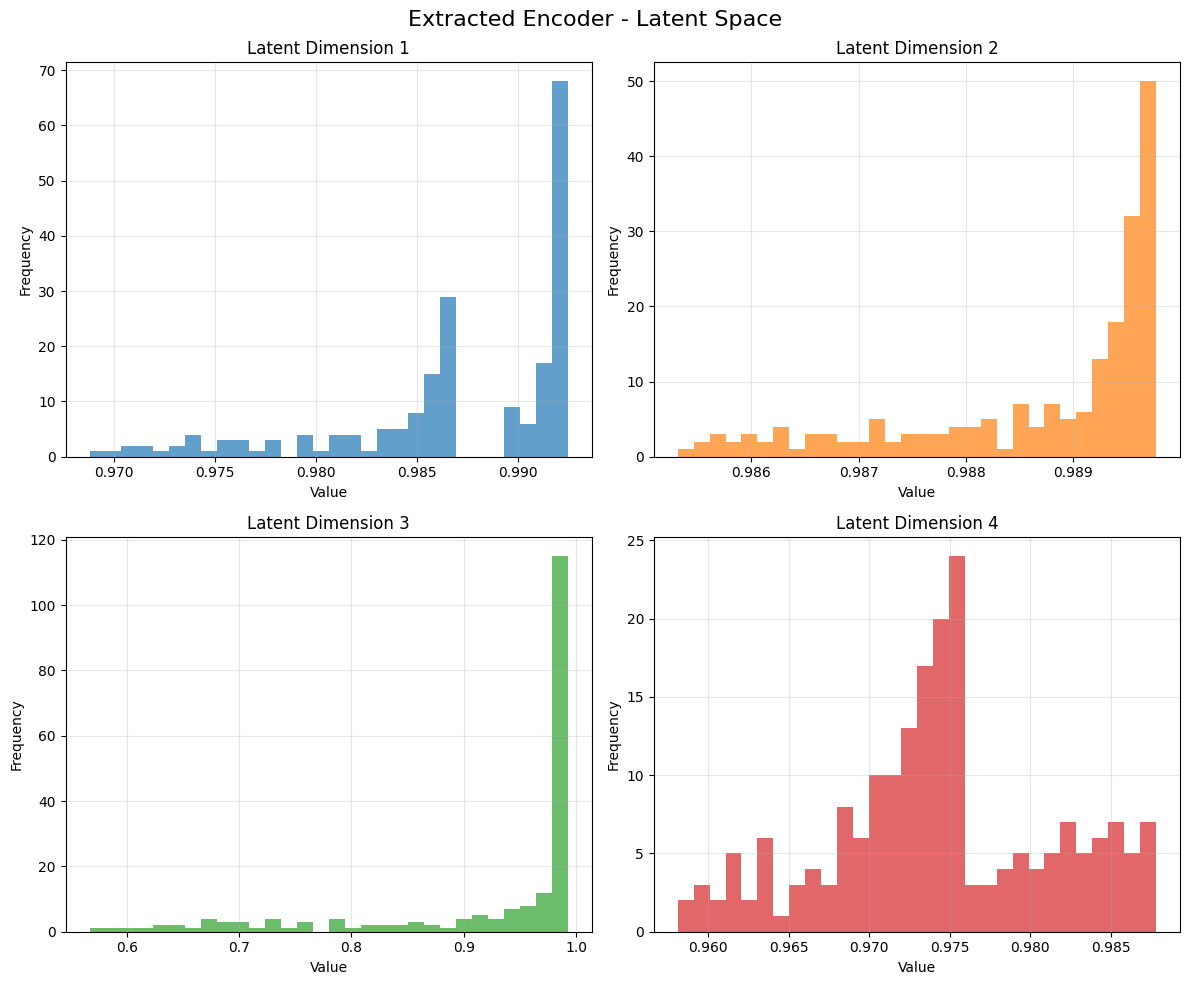


📈 잠재 공간 통계 (샘플 수: 200):
  - 형태: (200, 4)
  - 평균: [0.98701674 0.988712   0.92456543 0.97440183] ...
  - 표준편차: [0.0059924  0.00121526 0.10943869 0.00695052] ...
  - 최솟값: [0.96878743 0.9853179  0.56702435 0.9581101 ] ...
  - 최댓값: [0.99249667 0.9897683  0.99262846 0.9878208 ] ...
=== Encoder 사용법 데모 ===

1️⃣ 단일 상태 인코딩:
  입력 상태 형태: torch.Size([1, 4])
  잠재 상태 형태: torch.Size([1, 4])
  잠재 상태 값: [0.9912497  0.97711134 0.9453065 ] ...

2️⃣ 배치 처리:
  배치 입력 형태: torch.Size([10, 4])
  배치 잠재 출력 형태: torch.Size([10, 4])


In [24]:
def visualize_latent_space(encoder, data, title="Latent Space Representation", max_samples=200):
    """
    Encoder의 잠재 공간 표현을 시각화
    
    Args:
        encoder: StandaloneEncoder 모델
        data: 입력 데이터
        title: 그래프 제목
        max_samples: 최대 표시할 샘플 수
    """
    encoder.eval()
    
    # 데이터 준비
    if isinstance(data, dict) and 'demonstrations train' in data:
        # 데모 데이터 사용
        demo_data = data['demonstrations train']
        samples = demo_data[:max_samples//len(demo_data), ::10, :].reshape(-1, encoder.n_input)
        samples = samples[:max_samples]  # 최대 샘플 수 제한
    else:
        # 직접 제공된 데이터 사용
        samples = data[:max_samples]
    
    # Tensor로 변환
    samples_tensor = torch.FloatTensor(samples)
    if torch.cuda.is_available():
        samples_tensor = samples_tensor.cuda()
    
    # 잠재 공간으로 인코딩
    with torch.no_grad():
        latent_representations = encoder(samples_tensor).cpu().numpy()
    
    # 차원별 시각화
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(title, fontsize=16)
    
    # 처음 4개 차원 시각화
    for i in range(min(4, latent_representations.shape[1])):
        row, col = i // 2, i % 2
        axes[row, col].hist(latent_representations[:, i], bins=30, alpha=0.7, color=f'C{i}')
        axes[row, col].set_title(f'Latent Dimension {i+1}')
        axes[row, col].set_xlabel('Value')
        axes[row, col].set_ylabel('Frequency')
        axes[row, col].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 통계 정보 출력
    print(f"\n📈 잠재 공간 통계 (샘플 수: {len(latent_representations)}):")
    print(f"  - 형태: {latent_representations.shape}")
    print(f"  - 평균: {np.mean(latent_representations, axis=0)[:4]} ...")
    print(f"  - 표준편차: {np.std(latent_representations, axis=0)[:4]} ...")
    print(f"  - 최솟값: {np.min(latent_representations, axis=0)[:4]} ...")
    print(f"  - 최댓값: {np.max(latent_representations, axis=0)[:4]} ...")

def demonstrate_encoder_usage():
    """
    추출된 encoder의 실제 사용법 데모
    """
    print("=== Encoder 사용법 데모 ===")
    
    if 'standalone_encoder' not in globals():
        print("❌ standalone_encoder가 생성되지 않았습니다.")
        return
    
    # 1. 단일 상태 인코딩
    print("\n1️⃣ 단일 상태 인코딩:")
    single_state = torch.randn(1, standalone_encoder.n_input)
    if torch.cuda.is_available():
        single_state = single_state.cuda()
    
    with torch.no_grad():
        latent_state = standalone_encoder(single_state)
    
    print(f"  입력 상태 형태: {single_state.shape}")
    print(f"  잠재 상태 형태: {latent_state.shape}")
    print(f"  잠재 상태 값: {latent_state.cpu().numpy()[0][:3]} ...")
    
    # 2. 배치 처리
    print("\n2️⃣ 배치 처리:")
    batch_states = torch.randn(10, standalone_encoder.n_input)
    if torch.cuda.is_available():
        batch_states = batch_states.cuda()
    
    with torch.no_grad():
        batch_latent = standalone_encoder(batch_states)
    
    print(f"  배치 입력 형태: {batch_states.shape}")
    print(f"  배치 잠재 출력 형태: {batch_latent.shape}")
    
    # 3. 실제 데모 데이터 인코딩 (가능한 경우)
    if 'data' in locals():
        print("\n3️⃣ 실제 데모 데이터 인코딩:")
        demo_sample = data['demonstrations train'][0, :5, :].reshape(-1, standalone_encoder.n_input)  # 첫 데모의 5개 포인트
        demo_tensor = torch.FloatTensor(demo_sample)
        if torch.cuda.is_available():
            demo_tensor = demo_tensor.cuda()
        
        with torch.no_grad():
            demo_latent = standalone_encoder(demo_tensor)
        
        print(f"  데모 데이터 형태: {demo_tensor.shape}")
        print(f"  인코딩된 형태: {demo_latent.shape}")
        print(f"  첫 번째 포인트 잠재 표현: {demo_latent[0].cpu().numpy()[:3]} ...")

# 시각화 및 사용법 데모 실행
if 'standalone_encoder' in locals() and 'data' in locals():
    print("잠재 공간 시각화를 진행합니다...")
    visualize_latent_space(standalone_encoder, data, "Extracted Encoder - Latent Space")
    
    demonstrate_encoder_usage()
else:
    print("❌ 필요한 데이터나 모델이 없어 시각화를 수행할 수 없습니다.")

## 9. Latent Space 궤적 분석 및 시각화

이제 추출된 encoder를 사용하여 궤적을 latent space에서 분석하고 시각화해보겠습니다.

In [25]:
# 추가 분석 함수: 궤적 안정성 분석

def analyze_trajectories_stability_latent(demo_latent, sim_latent=None):
    """
    Latent space에서 궤적들의 안정성을 분석
    
    Args:
        demo_latent: 데모 궤적들의 latent space 표현 [n_demo, time_steps, latent_dim]
        sim_latent: 시뮬레이션 궤적들의 latent space 표현 [n_sim, time_steps, latent_dim] (선택사항)
    
    Returns:
        dict: 안정성 분석 결과
    """
    print("🔍 Latent Space 궤적 안정성 분석 시작...")
    
    # 분석할 궤적 결정
    if sim_latent is not None:
        trajectories_to_analyze = sim_latent
        analysis_type = "시뮬레이션"
    else:
        trajectories_to_analyze = demo_latent
        analysis_type = "데모"
    
    print(f"분석 대상: {analysis_type} 궤적 {len(trajectories_to_analyze)}개")
    
    # 각 궤적에 대해 Lyapunov 지수 계산
    lyapunov_results = []
    stable_count = 0
    
    # 데모 궤적을 기준으로 사용 (시뮬레이션 분석 시)
    reference_trajectories = demo_latent
    
    for i, trajectory in enumerate(trajectories_to_analyze):
        # 가장 유사한 데모 궤적 찾기
        if len(reference_trajectories) > 0:
            # 첫 번째 데모 궤적을 기준으로 사용 (또는 가장 유사한 것을 찾을 수 있음)
            demo_reference = reference_trajectories[0]  # 단순화를 위해 첫 번째 사용
            
            # R⁴ 거리 계산
            distance_traj, _ = get_closest_dist_traj_r4(
                torch.tensor(trajectory).unsqueeze(0),  # (1, time_steps, dim)
                torch.tensor(demo_reference)  # (time_steps, dim)
            )
            distance_traj = distance_traj.squeeze(0)  # (time_steps,)
        else:
            # 데모 기준이 없는 경우 자기 자신과의 거리 사용 (모든 점에서 0)
            distance_traj = torch.zeros(len(trajectory))
        
        # Lyapunov 지수 계산
        lyapunov, _ = calc_lyapunov_exponent_latent(distance_traj)
        
        # 결과가 텐서인 경우 스칼라로 변환
        if torch.is_tensor(lyapunov):
            if lyapunov.numel() == 1:
                lyapunov = lyapunov.item()
            else:
                lyapunov = lyapunov[0].item() if len(lyapunov) > 0 else float('nan')
        
        lyapunov_results.append(lyapunov)
        
        if lyapunov < 0:
            stable_count += 1
    
    lyapunov_results = np.array(lyapunov_results)
    
    # 통계 계산
    mean_lyapunov = np.mean(lyapunov_results)
    std_lyapunov = np.std(lyapunov_results)
    stable_ratio = stable_count / len(trajectories_to_analyze)
    
    # 결과 딕셔너리 생성
    results = {
        'lyapunov_exponents': lyapunov_results,
        'mean_lyapunov': mean_lyapunov,
        'std_lyapunov': std_lyapunov,
        'stable_count': stable_count,
        'total_count': len(trajectories_to_analyze),
        'stable_ratio': stable_ratio,
        'analysis_type': analysis_type
    }
    
    print(f"✓ 안정성 분석 완료!")
    print(f"  - 평균 Lyapunov 지수: {mean_lyapunov:.4f}")
    print(f"  - 표준편차: {std_lyapunov:.4f}")
    print(f"  - 안정한 궤적: {stable_count}/{len(trajectories_to_analyze)} ({stable_ratio:.2%})")
    
    return results

print("✓ analyze_trajectories_stability_latent 함수가 정의되었습니다!")

✓ analyze_trajectories_stability_latent 함수가 정의되었습니다!


In [26]:
# Latent Space 궤적 변환 및 분석 기능

import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def convert_trajectories_to_latent_space(encoder, trajectories, primitive_type=None):
    """
    궤적들을 latent space로 변환
    
    Args:
        encoder: StandaloneEncoder 모델
        trajectories: 원본 궤적들 [n_trajectories, time_steps, state_dim] 또는 [time_steps, state_dim]
        primitive_type: 원시타입 (multi-motion인 경우)
        
    Returns:
        latent_trajectories: latent space 궤적들
    """
    encoder.eval()
    
    # 입력 형태 확인 및 조정
    if trajectories.ndim == 2:
        # 단일 궤적인 경우
        trajectories = trajectories.unsqueeze(0)
        single_trajectory = True
    else:
        single_trajectory = False
    
    n_trajectories, time_steps, state_dim = trajectories.shape
    
    # Tensor로 변환
    if not isinstance(trajectories, torch.Tensor):
        trajectories = torch.FloatTensor(trajectories)
    
    if torch.cuda.is_available():
        trajectories = trajectories.cuda()
    
    latent_trajectories = []
    
    with torch.no_grad():
        for traj_idx in range(n_trajectories):
            traj_latent = []
            for time_idx in range(time_steps):
                state = trajectories[traj_idx, time_idx].unsqueeze(0)  # [1, state_dim]
                
                # Primitive type 설정
                if primitive_type is not None:
                    if isinstance(primitive_type, int):
                        prim_type = torch.tensor([primitive_type], dtype=torch.long)
                        if torch.cuda.is_available():
                            prim_type = prim_type.cuda()
                    else:
                        prim_type = primitive_type
                else:
                    prim_type = None
                
                # Latent space로 인코딩
                latent_state = encoder(state, prim_type)
                traj_latent.append(latent_state.cpu().numpy())
            
            latent_trajectories.append(np.concatenate(traj_latent, axis=0))
    
    latent_trajectories = np.array(latent_trajectories)  # [n_trajectories, time_steps, latent_dim]
    
    if single_trajectory:
        latent_trajectories = latent_trajectories.squeeze(0)
    
    return latent_trajectories

def plot_latent_space_trajectories(demo_latent, sim_latent=None, title="Latent Space Trajectories"):
    """
    Latent space에서 궤적들을 시각화
    
    Args:
        demo_latent: 데모 궤적들 [n_demos, time_steps, latent_dim]
        sim_latent: 시뮬레이션 궤적들 [n_sims, time_steps, latent_dim] (옵션)
        title: 그래프 제목
    """
    latent_dim = demo_latent.shape[-1]
    
    if latent_dim >= 4:
        # 4차원 이상인 경우 처음 4개 차원 사용
        fig = plt.figure(figsize=(16, 12))
        
        # 2D 투영들 (6개 subplot)
        projections = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]
        
        print(demo_latent.shape, sim_latent.shape if sim_latent is not None else None)
        
        for i, (dim1, dim2) in enumerate(projections):
            ax = fig.add_subplot(2, 3, i+1)
            
            # 데모 궤적들 그리기
            for demo_idx in range(len(demo_latent)):
                ax.plot(demo_latent[demo_idx, :, dim1], demo_latent[demo_idx, :, dim2], 
                       'b-', alpha=0.7, linewidth=4, label='Demo' if demo_idx == 0 else "")
                ax.scatter(demo_latent[demo_idx, 0, dim1], demo_latent[demo_idx, 0, dim2], 
                          c='blue', s=50, marker='o', alpha=0.8)
                ax.scatter(demo_latent[demo_idx, -1, dim1], demo_latent[demo_idx, -1, dim2], 
                          c='blue', s=50, marker='x', alpha=0.8)
            
            # 시뮬레이션 궤적들 그리기 (있는 경우)
            if sim_latent is not None:
                for sim_idx in range(sim_latent.shape[0]):
                    ax.plot(sim_latent[sim_idx,:, dim1], sim_latent[sim_idx,:, dim2], 
                           'r-', alpha=0.6, linewidth=1,label='Simulation' if sim_idx == 0 else "")
                    ax.scatter(sim_latent[sim_idx, 0, dim1], sim_latent[sim_idx, 0, dim2], 
                              c='red', s=30, marker='o', alpha=0.8)
                    ax.scatter(sim_latent[sim_idx, -1, dim1], sim_latent[sim_idx, -1, dim2], 
                              c='red', s=30, marker='x', alpha=0.8)
            
            ax.set_xlabel(f'Latent Dim {dim1+1}')
            ax.set_ylabel(f'Latent Dim {dim2+1}')
            ax.set_title(f'Dimensions {dim1+1} vs {dim2+1}')
            ax.grid(True, alpha=0.3)
            if i == 0:
                ax.legend()
        
        plt.suptitle(f'{title} - 2D Projections', fontsize=16)
        plt.tight_layout()
        plt.show()
        
        # 3D 시각화 (첫 3개 차원)
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # 데모 궤적들
        for demo_idx in range(len(demo_latent)):
            ax.plot(demo_latent[demo_idx, :, 0], demo_latent[demo_idx, :, 1], demo_latent[demo_idx, :, 2],
                   'b-', alpha=0.7, linewidth=2, label='Demo' if demo_idx == 0 else "")
            ax.scatter(demo_latent[demo_idx, 0, 0], demo_latent[demo_idx, 0, 1], demo_latent[demo_idx, 0, 2],
                      c='blue', s=50, marker='o')
            ax.scatter(demo_latent[demo_idx, -1, 0], demo_latent[demo_idx, -1, 1], demo_latent[demo_idx, -1, 2],
                      c='blue', s=50, marker='x')

        # 시뮬레이션 궤적들 (있는 경우)
        if sim_latent is not None:
            for sim_idx in range(sim_latent.shape[0]):
                ax.plot(sim_latent[sim_idx,:, 0], sim_latent[sim_idx,:, 1], sim_latent[sim_idx,:, 2],
                       'r-', alpha=0.6, linewidth=1, label='Simulation' if sim_idx == 0 else "")
                ax.scatter(sim_latent[sim_idx, 0, 0], sim_latent[sim_idx, 0, 1], sim_latent[sim_idx, 0, 2],
                          c='red', s=30, marker='o')
                ax.scatter(sim_latent[sim_idx, -1, 0], sim_latent[sim_idx, -1, 1], sim_latent[sim_idx, -1, 2],
                          c='red', s=30, marker='x')

        ax.set_xlabel('Latent Dim 1')
        ax.set_ylabel('Latent Dim 2')
        ax.set_zlabel('Latent Dim 3')
        ax.set_title(f'{title} - 3D View (Dims 1-3)')
        ax.legend()
        plt.show()
        
    elif latent_dim == 3:
        # 3차원인 경우
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # 데모 궤적들
        for demo_idx in range(len(demo_latent)):
            ax.plot(demo_latent[demo_idx, :, 0], demo_latent[demo_idx, :, 1], demo_latent[demo_idx, :, 2],
                   'b-', alpha=0.7, linewidth=2, label='Demo' if demo_idx == 0 else "")
        
        # 시뮬레이션 궤적들 (있는 경우)
        if sim_latent is not None:
            for sim_idx in range(len(sim_latent)):
                ax.plot(sim_latent[sim_idx, :, 0], sim_latent[sim_idx, :, 1], sim_latent[sim_idx, :, 2],
                       'r-', alpha=0.6, linewidth=1, label='Simulation' if sim_idx == 0 else "")
        
        ax.set_xlabel('Latent Dim 1')
        ax.set_ylabel('Latent Dim 2')
        ax.set_zlabel('Latent Dim 3')
        ax.set_title(title)
        ax.legend()
        plt.show()
        
    else:
        # 2차원인 경우
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # 데모 궤적들
        for demo_idx in range(len(demo_latent)):
            ax.plot(demo_latent[demo_idx, :, 0], demo_latent[demo_idx, :, 1],
                   'b-', alpha=0.7, linewidth=2, label='Demo' if demo_idx == 0 else "")
        
        # 시뮬레이션 궤적들 (있는 경우)
        if sim_latent is not None:
            for sim_idx in range(len(sim_latent)):
                ax.plot(sim_latent[sim_idx, :, 0], sim_latent[sim_idx, :, 1],
                       'r-', alpha=0.6, linewidth=1, label='Simulation' if sim_idx == 0 else "")
        
        ax.set_xlabel('Latent Dim 1')
        ax.set_ylabel('Latent Dim 2')
        ax.set_title(title)
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.show()

def get_closest_dist_traj_r4(sample_traj, demo_traj, search_window=50, unique_indices=None):
    """
    R^4 (latent space)에서 궤적 간 최근접 거리 계산 (Lyapunov 지수용)
    
    Args:
        sample_traj: (nb, nt1, 4) - 시뮬레이션된 latent 궤적들
        demo_traj: (nt2, 4) - 데모 latent 궤적
        search_window: 탐색 윈도우 크기
        unique_indices: 고유 인덱스
    """
    eps = 1e-10
    
    nb, nt1, dim = sample_traj.shape
    nt2, _ = demo_traj.shape

    # 거리 궤적 초기화
    dist_min = torch.zeros(nb, nt1)
    closest_idx_list = torch.zeros(nb, nt1, dtype=torch.long)
    
    for batch_idx in range(nb):
        prev_closest_idx = 0  # 데모 궤적 시작점부터 시작
        
        for time_idx in range(nt1):
            current_point = sample_traj[batch_idx, time_idx]  # (dim,)
            
            if time_idx == 0:
                # 첫 번째 시간 스텝에서는 전체 데모 궤적 탐색
                if unique_indices is not None:
                    search_start = max(0, unique_indices - search_window)
                    search_end = min(nt2, unique_indices + search_window + 40)
                else:
                    search_start = 0
                    search_end = nt2
                demo_window = demo_traj[search_start:search_end]
            else:
                # 이전 최근접점 주변에서 탐색 윈도우 정의
                search_start = max(0, prev_closest_idx - search_window)
                search_end = min(nt2, prev_closest_idx + search_window + 1)
                demo_window = demo_traj[search_start:search_end]  # (window_size, dim)
    
            # 윈도우 내 점들과의 거리 계산 (유클리드 거리)
            distances = torch.norm(current_point.unsqueeze(0) - demo_window, dim=-1)  # (window_size,)
            
            # 최소 거리와 인덱스 찾기
            min_idx_in_window = torch.argmin(distances)
            min_distance = distances[min_idx_in_window]
            
            # 전역 인덱스로 변환
            closest_idx = search_start + min_idx_in_window
        
            # 거리 저장 및 이전 최근접 인덱스 업데이트
            dist_min[batch_idx, time_idx] = min_distance
            prev_closest_idx = closest_idx
            closest_idx_list[batch_idx, time_idx] = closest_idx

    dist_min = torch.clamp(dist_min, min=eps)
    return dist_min, closest_idx_list

def calc_lyapunov_exponent_latent(distance_traj, terminal_time=1, eps=1e-6):
    """
    Latent space에서 거리 궤적으로부터 Lyapunov 지수 계산 (단순화 버전)
    
    Args:
        distance_traj: Lyapunov 계산을 위한 거리 궤적
        terminal_time: 정규화를 위한 종료 시간
        eps: 절단을 위한 거리 임계값
    """
    input_size = distance_traj.shape
    
    if len(input_size) == 2:
        multitraj = True
    else:
        multitraj = False
        distance_traj = distance_traj.unsqueeze(0)
    
    lamb_list = []
    
    for i in range(len(distance_traj)):
        truncation_point = len(distance_traj[i])  # 기본값: 전체 궤적 사용
        
        # eps 기반 절단 확인
        for j in range(len(distance_traj[i])):
            if distance_traj[i][j] < eps:
                print(f"궤적 {i}: eps 절단 at step {j}, dist={distance_traj[i][j]:.6f}")
                truncation_point = j + 1
                break
        
        # 절단 적용
        distance_truncated = distance_traj[i][:truncation_point]
        
        if len(distance_truncated) < 2:
            lamb_list.append(float('nan'))
            continue
            
        log_dist_traj = torch.log(distance_truncated).unsqueeze(-1)
        log_d0 = log_dist_traj[..., 0:1, 0:1]
        t_linspace = torch.linspace(0, terminal_time, len(distance_truncated), dtype=torch.float64).to(log_d0)
        
        try:
            lamb = (torch.pinverse(t_linspace.unsqueeze(-1)) @ (log_d0 - log_dist_traj)).squeeze().squeeze()
            lamb_list.append(lamb)
        except:
            lamb_list.append(float('nan'))
            
    lamb = torch.tensor(lamb_list)
    return lamb, truncation_point

def analyze_latent_space_statistics(demo_latent, sim_latent=None):
    """
    Latent space에서 궤적들의 통계 분석
    """
    print("=== Latent Space 통계 분석 ===")
    
    # 데모 궤적 통계
    demo_mean = np.mean(demo_latent, axis=(0, 1))
    demo_std = np.std(demo_latent, axis=(0, 1))
    demo_range = (np.min(demo_latent, axis=(0, 1)), np.max(demo_latent, axis=(0, 1)))
    
    print("\n📊 데모 궤적 (Latent Space):")
    print(f"  - 형태: {demo_latent.shape}")
    print(f"  - 평균: {demo_mean}")
    print(f"  - 표준편차: {demo_std}")
    print(f"  - 범위: {demo_range[0]} ~ {demo_range[1]}")
    
    if sim_latent is not None:
        # 시뮬레이션 궤적 통계
        sim_mean = np.mean(sim_latent, axis=(0, 1))
        sim_std = np.std(sim_latent, axis=(0, 1))
        sim_range = (np.min(sim_latent, axis=(0, 1)), np.max(sim_latent, axis=(0, 1)))
        
        print("\n📊 시뮬레이션 궤적 (Latent Space):")
        print(f"  - 형태: {sim_latent.shape}")
        print(f"  - 평균: {sim_mean}")
        print(f"  - 표준편차: {sim_std}")
        print(f"  - 범위: {sim_range[0]} ~ {sim_range[1]}")
        
        # 평균 차이 분석
        mean_diff = np.abs(demo_mean - sim_mean)
        print(f"\n🔍 평균 차이: {mean_diff}")
        print(f"🔍 평균 차이 크기: {np.linalg.norm(mean_diff):.6f}")

print("✓ Latent space 궤적 분석 함수들이 정의되었습니다!")

✓ Latent space 궤적 분석 함수들이 정의되었습니다!


=== 데모 궤적 Latent Space 분석 ===
(1, 2000, 2)
데모 궤적 형태 (task space): (1, 2000, 2), 속도 형태: (1, 2000, 2)
데모 궤적 형태 (task space): (1, 2000, 4)
데모 궤적을 latent space로 변환 중...
데모 궤적 형태 (latent space): (1, 2000, 4)

=== Latent Space 궤적 시각화 ===
(1, 2000, 4) None


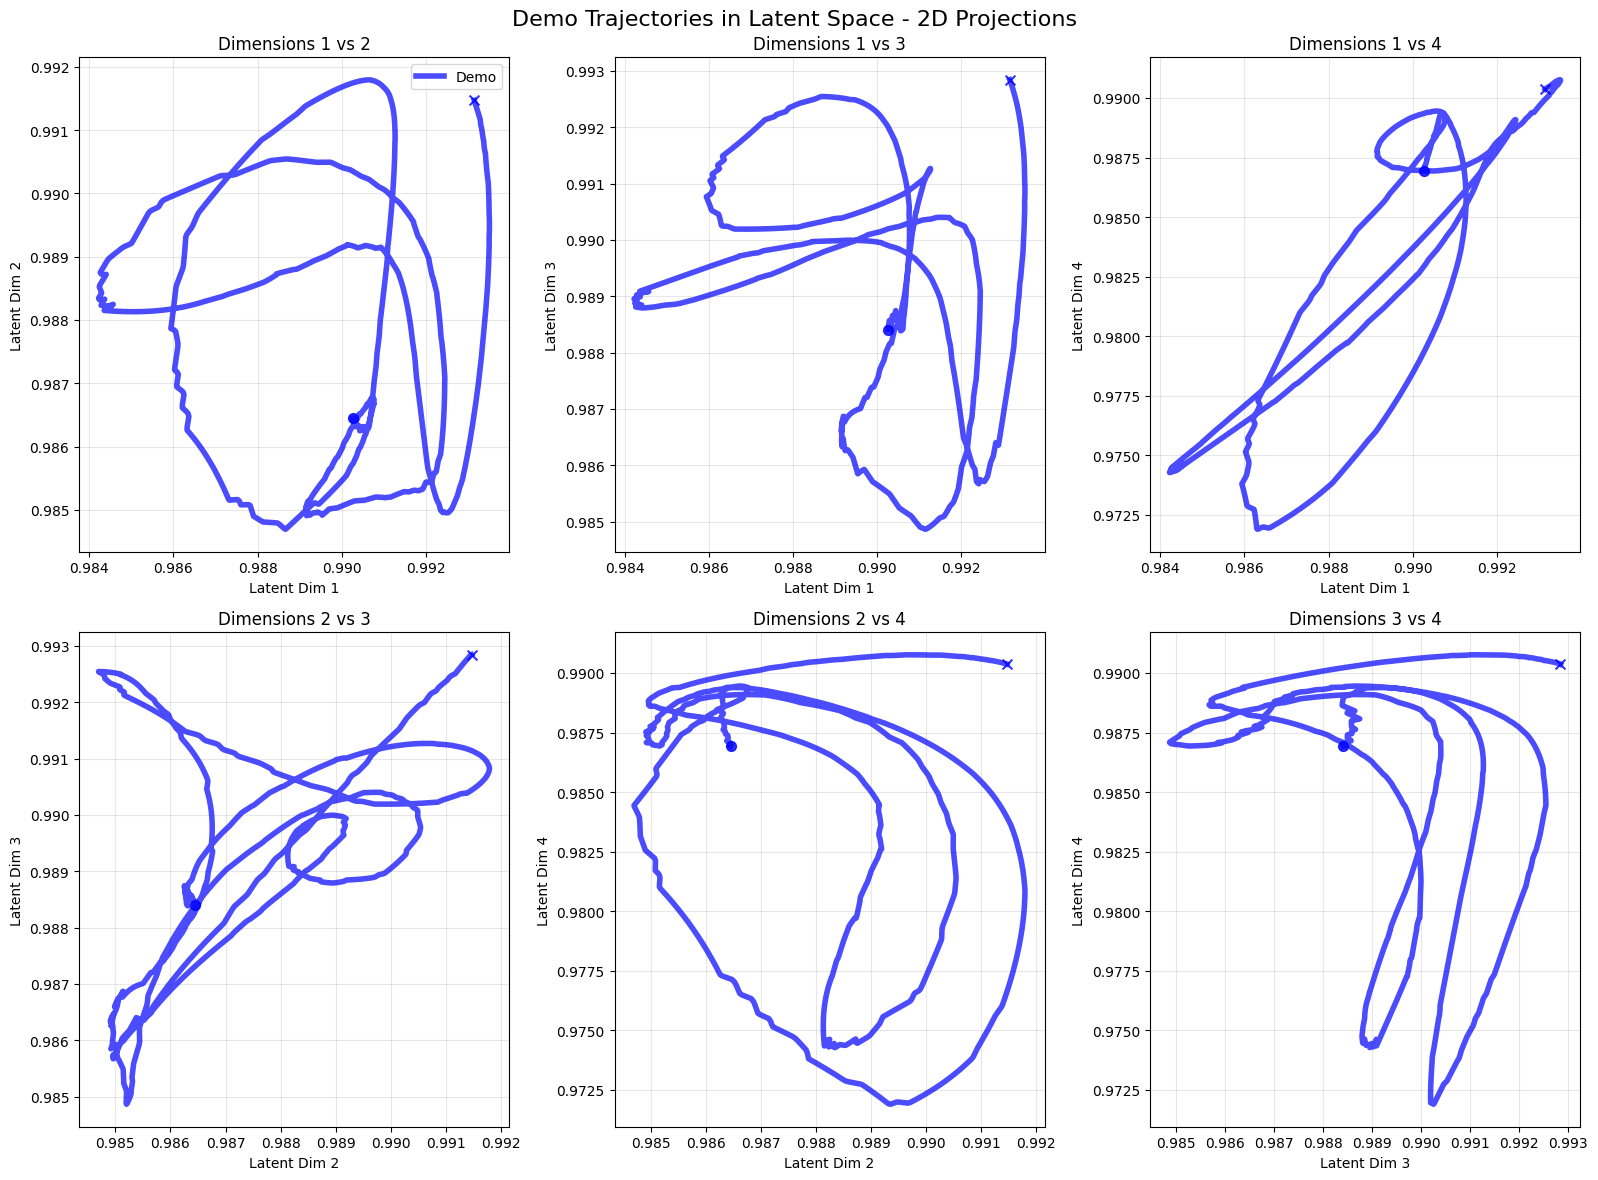

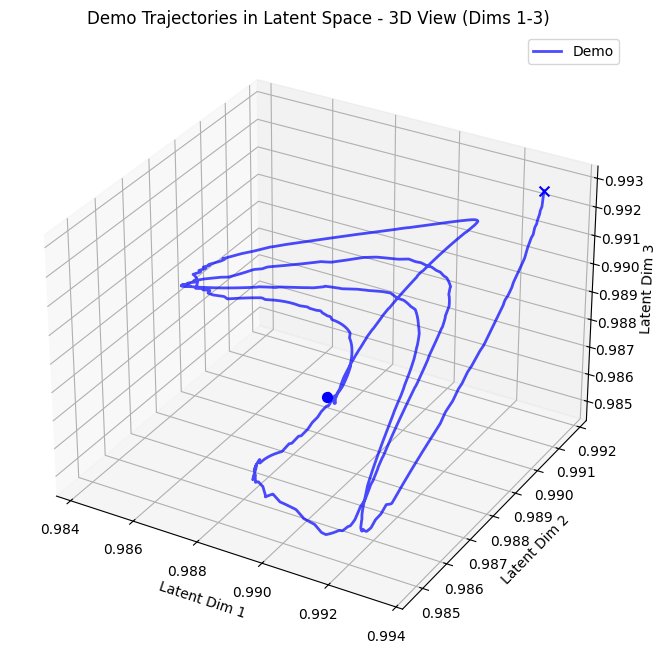

=== Latent Space 통계 분석 ===

📊 데모 궤적 (Latent Space):
  - 형태: (1, 2000, 4)
  - 평균: [0.9901854  0.9874824  0.9891766  0.98524404]
  - 표준편차: [0.00228117 0.00204286 0.0020025  0.00526325]
  - 범위: [0.98422134 0.9846945  0.9848661  0.9718947 ] ~ [0.99351263 0.99179405 0.9928407  0.9907618 ]

✅ 데모 궤적 latent space 분석 완료!


In [27]:
# 데모 궤적 Latent Space 변환 및 시각화 실행

if 'standalone_encoder' in locals() and 'data' in locals():
    print("=== 데모 궤적 Latent Space 분석 ===")
    
    # 데모 궤적 추출
    demonstrations_eval = data['demonstrations train'][..., 0]
    print(demonstrations_eval.shape)
    demonstrations_velocity = demonstrations_eval[:, 1:,:] - demonstrations_eval[:, :-1,:]  # 속도 계
    demonstrations_velocity = np.concatenate((demonstrations_velocity, np.zeros((demonstrations_velocity.shape[0], 1, demonstrations_velocity.shape[2]))), axis=1)  # 마지막에 0 추가
    print(f"데모 궤적 형태 (task space): {demonstrations_eval.shape}, 속도 형태: {demonstrations_velocity.shape}")
    demonstrations_eval = np.concatenate((demonstrations_eval, demonstrations_velocity), axis=2)  # 속도 포함
    print(f"데모 궤적 형태 (task space): {demonstrations_eval.shape}")
    
    # Latent space로 변환
    print("데모 궤적을 latent space로 변환 중...")
    demo_latent = convert_trajectories_to_latent_space(standalone_encoder, demonstrations_eval)
    print(f"데모 궤적 형태 (latent space): {demo_latent.shape}")
    
    # Latent space 시각화
    print("\n=== Latent Space 궤적 시각화 ===")
    plot_latent_space_trajectories(demo_latent, title="Demo Trajectories in Latent Space")
    
    # 통계 분석
    analyze_latent_space_statistics(demo_latent)
    
    print("\n✅ 데모 궤적 latent space 분석 완료!")
    
else:
    print("❌ 필요한 구성요소가 없어 latent space 분석을 수행할 수 없습니다.")
    print("필요: standalone_encoder, data")

In [28]:
# 시뮬레이션 궤적 생성 및 Latent Space 비교 분석

if 'standalone_encoder' in locals() and 'learner' in locals() and 'data' in locals():
    print("=== 시뮬레이션 궤적 생성 및 Latent Space 분석 ===")
    
    # 1. 초기 상태 샘플링 (데모 시작점 근처)
    def create_initial_states_from_demos(num_samples=10, noise_std=0.05):
        """
        데모 궤적의 시작점 근처에서 초기 상태 샘플링
        """
        demonstrations_eval = data['demonstrations train'][..., 0]
        all_start_positions = []
        all_start_velocities = []
        
        for demo in demonstrations_eval:
            # 데모의 시작점 (첫 번째 포인트) 사용
            start_position = demo[0, :2]  # 첫 번째 타임스텝의 위치
            
            # 시작 속도 계산 (첫 번째와 두 번째 포인트 차이)
            if len(demo) > 1:
                start_velocity = (demo[1, :2] - demo[0, :2]) / params.delta_t
            else:
                start_velocity = np.zeros(2)
            
            all_start_positions.append(start_position)
            all_start_velocities.append(start_velocity)
        
        # numpy 배열로 변환
        all_start_positions = np.array(all_start_positions)
        all_start_velocities = np.array(all_start_velocities)
        
        # 평균 시작점 계산
        mean_start_position = np.mean(all_start_positions, axis=0)
        mean_start_velocity = np.mean(all_start_velocities, axis=0)
        
        print(f"평균 시작점: {mean_start_position}")
        print(f"평균 시작 속도: {mean_start_velocity}")
        
        # 시작점 근처에서 샘플링
        sampled_positions = []
        sampled_velocities = []
        
        for i in range(num_samples):
            # 시작점 근처에서 가우시안 노이즈로 샘플링
            noise_position = np.random.normal(0, noise_std, size=2)
            noise_velocity = np.random.normal(0, noise_std * 0.5, size=2)  # 속도는 작은 노이즈
            
            sample_position = mean_start_position + noise_position
            sample_velocity = mean_start_velocity + noise_velocity
            
            sampled_positions.append(sample_position)
            sampled_velocities.append(sample_velocity)
        
        # numpy 배열로 변환
        x_t_init_positions = np.array(sampled_positions)
        x_t_init_velocities = np.array(sampled_velocities)
        
        # 위치와 속도 결합
        x_t_init = np.hstack((x_t_init_positions, x_t_init_velocities))
        
        print(f"생성된 초기 상태 수: {x_t_init.shape[0]}")
        print(f"위치 범위: [{x_t_init_positions.min():.3f}, {x_t_init_positions.max():.3f}]")
        print(f"속도 범위: [{x_t_init_velocities.min():.3f}, {x_t_init_velocities.max():.3f}]")
        
        return torch.FloatTensor(x_t_init)
    
    # 2. 동적 시스템을 사용한 궤적 시뮬레이션
    def simulate_trajectories_with_extracted_encoder(encoder, learner, initial_states, simulation_length, delta_t):
        """
        추출된 encoder를 사용하여 궤적 시뮬레이션
        """
        print(f"궤적 시뮬레이션 시작 (길이: {simulation_length}, 초기 상태: {initial_states.shape[0]}개)")
        
        # GPU로 이동
        if torch.cuda.is_available():
            initial_states = initial_states.cuda()
        
        # 동적 시스템 초기화
        dynamical_system = learner.init_dynamical_system(
            initial_states=initial_states, 
            delta_t=delta_t
        )
        
        # Encoder 교체 (독립적인 encoder 사용)
        original_encoder = dynamical_system.model.encoder
        # dynamical_system.model.encoder = lambda x, p: encoder(x, p)
        
        # 궤적 시뮬레이션
        simulated_trajectories = [initial_states.cpu().detach().numpy()]
        
        for i in range(simulation_length):
            if i % 100 == 0:
                print(f"  스텝 {i}/{simulation_length}")
            
            # 전이 수행
            x_t = dynamical_system.transition(space='task')['desired state']
            simulated_trajectories.append(x_t.cpu().detach().numpy())
        
        # numpy 배열로 변환
        simulated_trajectories = np.array(simulated_trajectories)  # (time+1, n_trajectories, state_dim)
        
        print(f"✓ 시뮬레이션 완료! 출력 형태: {simulated_trajectories.shape}")
        return simulated_trajectories
    
    # 시뮬레이션 매개변수
    num_samples = 10
    simulation_length = 1500
    noise_std = 0.1
    
    print(f"시뮬레이션 설정:")
    print(f"  - 초기 상태 샘플 수: {num_samples}")
    print(f"  - 시뮬레이션 길이: {simulation_length}")
    print(f"  - 노이즈 표준편차: {noise_std}")
    
    # 초기 상태 생성
    initial_states = create_initial_states_from_demos(
        num_samples=num_samples, 
        noise_std=noise_std
    )
    print(f"초기 상태 형태: {initial_states.shape}")
    
    # 궤적 시뮬레이션 실행
    simulated_trajectories = simulate_trajectories_with_extracted_encoder(
        standalone_encoder, 
        learner, 
        initial_states, 
        simulation_length, 
        params.delta_t
    )
    
    print(f"\n📊 시뮬레이션 결과:")
    print(f"  - 궤적 개수: {simulated_trajectories.shape[1]}")
    print(f"  - 시뮬레이션 길이: {simulated_trajectories.shape[0]}")
    print(f"  - 상태 차원: {simulated_trajectories.shape[2]}")
    
else:
    print("❌ 필요한 구성요소가 없어 시뮬레이션을 수행할 수 없습니다.")
    print("필요: standalone_encoder, learner, data")

=== 시뮬레이션 궤적 생성 및 Latent Space 분석 ===
시뮬레이션 설정:
  - 초기 상태 샘플 수: 10
  - 시뮬레이션 길이: 1500
  - 노이즈 표준편차: 0.1
평균 시작점: [-0.76923077  0.54718477]
평균 시작 속도: [0.53500263 0.        ]
생성된 초기 상태 수: 10
위치 범위: [-0.956, 0.570]
속도 범위: [-0.063, 0.633]
초기 상태 형태: torch.Size([10, 4])
궤적 시뮬레이션 시작 (길이: 1500, 초기 상태: 10개)
  스텝 0/1500
  스텝 100/1500
  스텝 200/1500
  스텝 300/1500
  스텝 400/1500
  스텝 500/1500
  스텝 600/1500
  스텝 700/1500
  스텝 800/1500
  스텝 900/1500
  스텝 1000/1500
  스텝 1100/1500
  스텝 1200/1500
  스텝 1300/1500
  스텝 1400/1500
  스텝 700/1500
  스텝 800/1500
  스텝 900/1500
  스텝 1000/1500
  스텝 1100/1500
  스텝 1200/1500
  스텝 1300/1500
  스텝 1400/1500
✓ 시뮬레이션 완료! 출력 형태: (1501, 10, 4)

📊 시뮬레이션 결과:
  - 궤적 개수: 10
  - 시뮬레이션 길이: 1501
  - 상태 차원: 4
✓ 시뮬레이션 완료! 출력 형태: (1501, 10, 4)

📊 시뮬레이션 결과:
  - 궤적 개수: 10
  - 시뮬레이션 길이: 1501
  - 상태 차원: 4


=== Simulated Trajectory Latent Space Analysis ===


✓ Simulated trajectory latent space conversion completed:
  - Original shape: (1501, 10, 4)
  - Latent shape: (10, 1501, 4)

📈 Latent Space Trajectory Visualization
(1, 2000, 4) (10, 1501, 4)


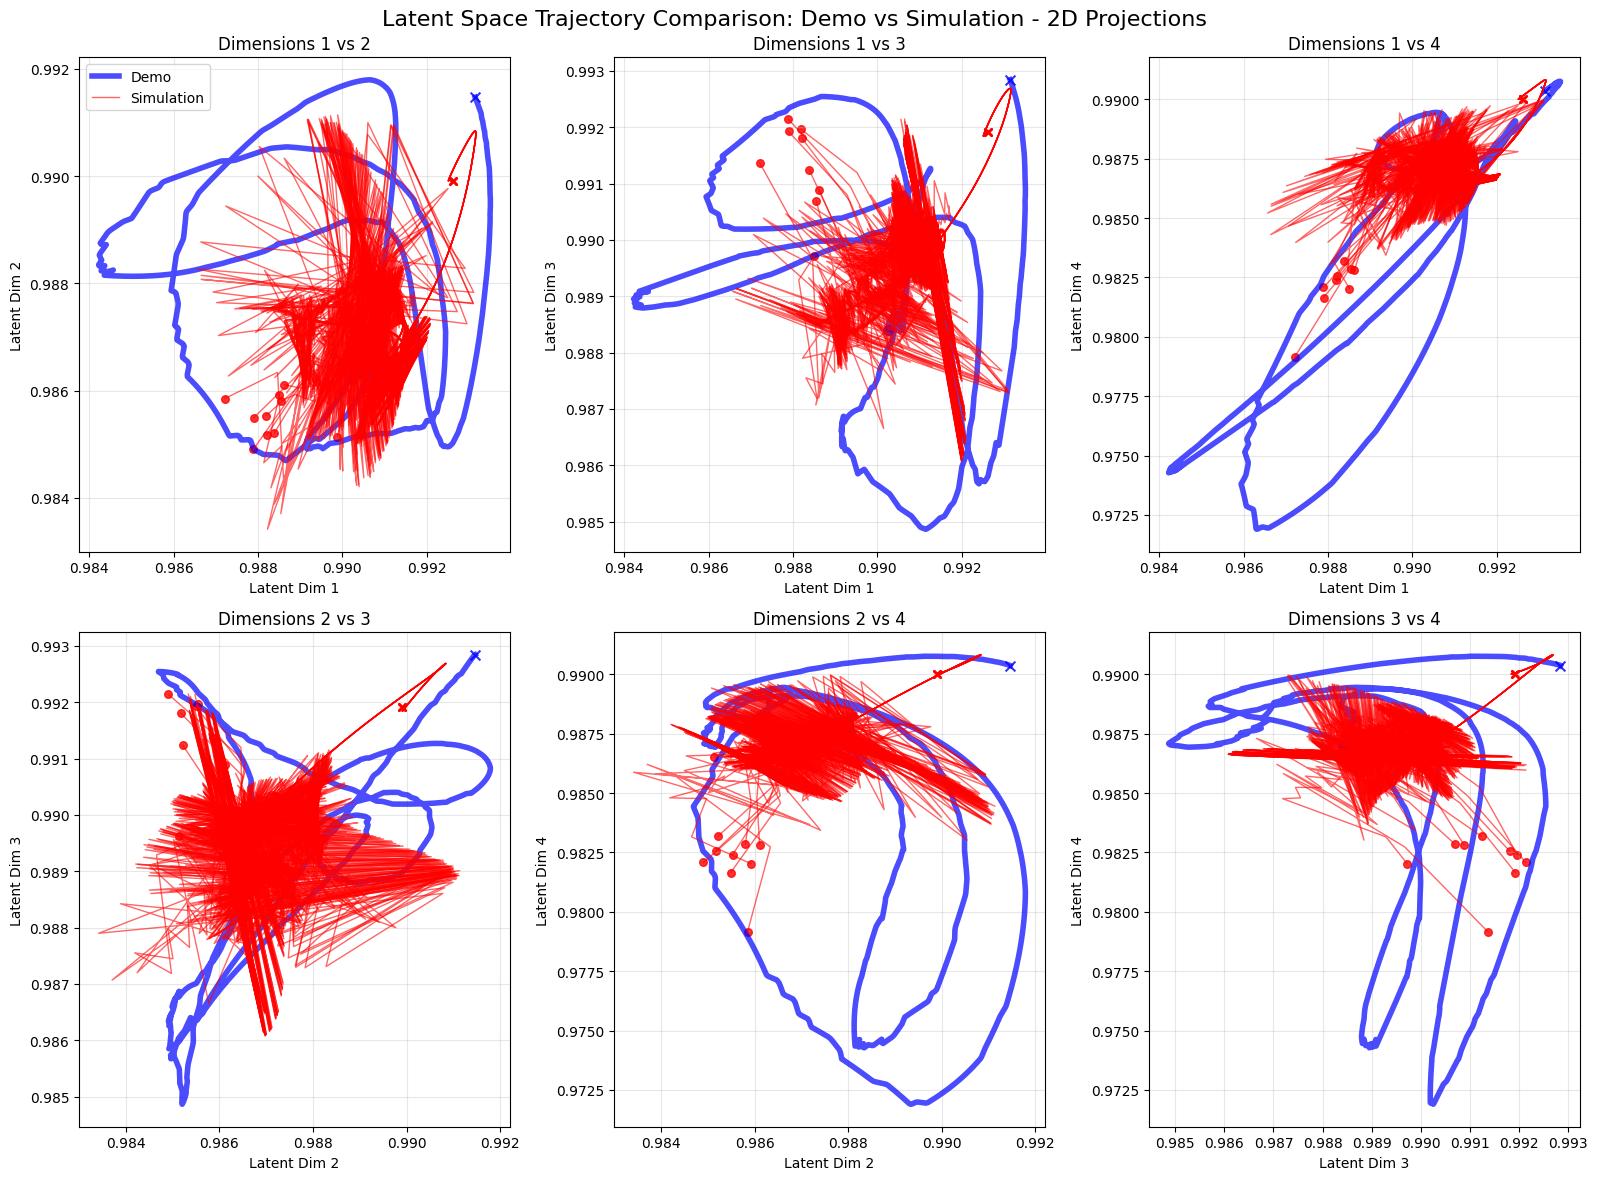

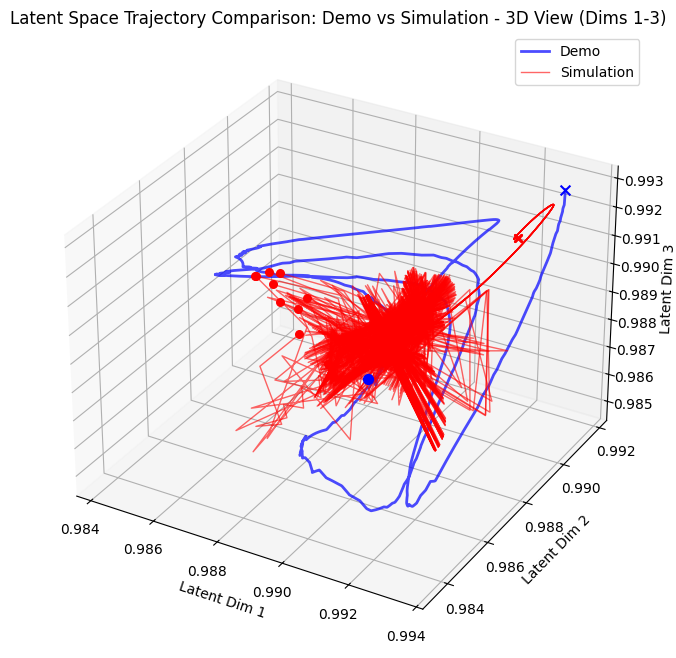


🔍 Simulated Trajectory Stability Analysis
🔍 Latent Space 궤적 안정성 분석 시작...
분석 대상: 시뮬레이션 궤적 10개
✓ 안정성 분석 완료!
  - 평균 Lyapunov 지수: -2.0346
  - 표준편차: 1.1514
  - 안정한 궤적: 10/10 (100.00%)

📊 Stability Analysis Results:
  - Number of demo trajectories: 1
  - Number of simulated trajectories: 10
  - Mean Lyapunov exponent: -2.0346
  - Lyapunov standard deviation: 1.1514
  - Stable trajectory ratio: 100.00%

🧮 Individual Trajectory Lyapunov Exponent Analysis
  Trajectory 1: Lyapunov = -0.5451 (Stable)
  Trajectory 2: Lyapunov = -1.7177 (Stable)
  Trajectory 3: Lyapunov = -2.9058 (Stable)
  Trajectory 4: Lyapunov = -1.0327 (Stable)
  Trajectory 5: Lyapunov = -2.6189 (Stable)
  Trajectory 6: Lyapunov = -4.1752 (Stable)
✓ 안정성 분석 완료!
  - 평균 Lyapunov 지수: -2.0346
  - 표준편차: 1.1514
  - 안정한 궤적: 10/10 (100.00%)

📊 Stability Analysis Results:
  - Number of demo trajectories: 1
  - Number of simulated trajectories: 10
  - Mean Lyapunov exponent: -2.0346
  - Lyapunov standard deviation: 1.1514
  - Stable traj

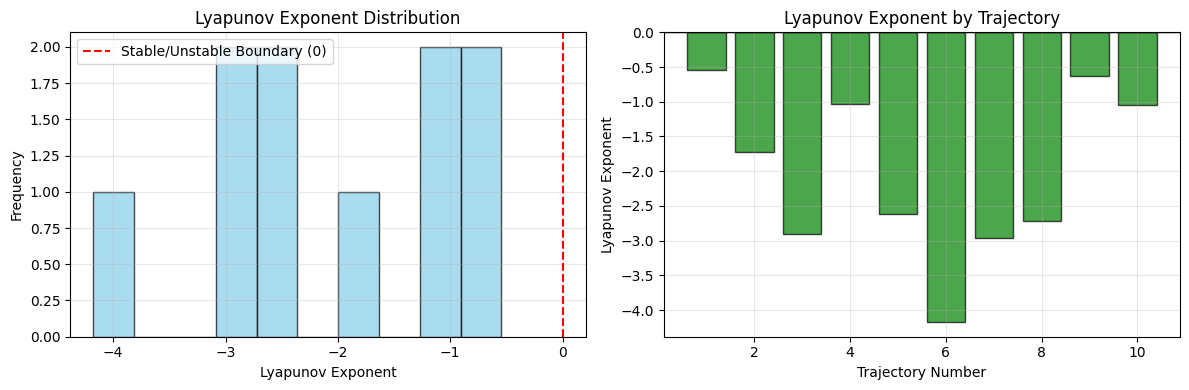


📋 Final Analysis Summary:
  - Total number of trajectories: 10
  - Stable trajectories: 10 (100.0%)
  - Unstable trajectories: 0 (0.0%)
  - Mean Lyapunov: -2.0346
  - Min Lyapunov: -4.1752
  - Max Lyapunov: -0.5451
(10, 1501, 4)


In [29]:
# Simulated Trajectory Latent Space Analysis and Lyapunov Exponent Calculation

if 'simulated_trajectories' in locals() and 'standalone_encoder' in locals():
    print("=== Simulated Trajectory Latent Space Analysis ===")
    
    # 1. Convert simulated trajectories to latent space
    sim_latent_trajectories = convert_trajectories_to_latent_space(
        standalone_encoder,
        simulated_trajectories
    )
    
    sim_latent_trajectories = sim_latent_trajectories.transpose(1,0,2)  # (time_steps, n_trajectories, latent_dim)
    
    
    print(f"✓ Simulated trajectory latent space conversion completed:")
    print(f"  - Original shape: {simulated_trajectories.shape}")
    print(f"  - Latent shape: {sim_latent_trajectories.shape}")
    
    # 2. Trajectory visualization in latent space
    print("\n📈 Latent Space Trajectory Visualization")
    plot_latent_space_trajectories(
        demo_latent=demo_latent,
        sim_latent=sim_latent_trajectories,
        title="Latent Space Trajectory Comparison: Demo vs Simulation"
    )
    
    # 3. Stability analysis of simulated trajectories
    print("\n🔍 Simulated Trajectory Stability Analysis")
    stability_results = analyze_trajectories_stability_latent(
        demo_latent, 
        sim_latent_trajectories
    )
    
    print(f"\n📊 Stability Analysis Results:")
    print(f"  - Number of demo trajectories: {len(demo_latent)}")
    print(f"  - Number of simulated trajectories: {len(sim_latent_trajectories)}")
    print(f"  - Mean Lyapunov exponent: {stability_results['mean_lyapunov']:.4f}")
    print(f"  - Lyapunov standard deviation: {stability_results['std_lyapunov']:.4f}")
    print(f"  - Stable trajectory ratio: {stability_results['stable_ratio']:.2%}")
    
    # 4. Individual trajectory Lyapunov exponent calculation and analysis
    print("\n🧮 Individual Trajectory Lyapunov Exponent Analysis")
    individual_lyapunov = []
    
    for i, traj in enumerate(sim_latent_trajectories):
        # 데모 궤적과의 거리 계산
        if len(demo_latent) > 0:
            demo_reference = demo_latent[0]  # 첫 번째 데모 궤적을 기준으로 사용
            distance_traj, _ = get_closest_dist_traj_r4(
                torch.tensor(traj).unsqueeze(0),  # (1, time_steps, dim)
                torch.tensor(demo_reference)  # (time_steps, dim)
            )
            distance_traj = distance_traj.squeeze(0)  # (time_steps,)
            
            lyapunov, _ = calc_lyapunov_exponent_latent(distance_traj)
            
            # 결과가 텐서인 경우 스칼라로 변환
            if torch.is_tensor(lyapunov):
                if lyapunov.numel() == 1:
                    lyapunov = lyapunov.item()
                else:
                    lyapunov = lyapunov[0].item() if len(lyapunov) > 0 else float('nan')
        else:
            lyapunov = float('nan')
        
        individual_lyapunov.append(lyapunov)
        stability_status = "Stable" if lyapunov < 0 else "Unstable"
        print(f"  Trajectory {i+1}: Lyapunov = {lyapunov:.4f} ({stability_status})")
    
    individual_lyapunov = np.array(individual_lyapunov)
    
    # 5. Lyapunov exponent distribution visualization
    print("\n📊 Lyapunov Exponent Distribution Visualization")
    plt.figure(figsize=(12, 4))
    
    # Histogram
    plt.subplot(1, 2, 1)
    plt.hist(individual_lyapunov, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(x=0, color='red', linestyle='--', label='Stable/Unstable Boundary (0)')
    plt.xlabel('Lyapunov Exponent')
    plt.ylabel('Frequency')
    plt.title('Lyapunov Exponent Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Lyapunov exponent by trajectory
    plt.subplot(1, 2, 2)
    colors = ['green' if lyap < 0 else 'red' for lyap in individual_lyapunov]
    plt.bar(range(1, len(individual_lyapunov) + 1), individual_lyapunov, 
            color=colors, alpha=0.7, edgecolor='black')
    plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
    plt.xlabel('Trajectory Number')
    plt.ylabel('Lyapunov Exponent')
    plt.title('Lyapunov Exponent by Trajectory')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 6. Final statistical summary
    stable_count = np.sum(individual_lyapunov < 0)
    unstable_count = np.sum(individual_lyapunov >= 0)
    
    print(f"\n📋 Final Analysis Summary:")
    print(f"  - Total number of trajectories: {len(individual_lyapunov)}")
    print(f"  - Stable trajectories: {stable_count} ({stable_count/len(individual_lyapunov)*100:.1f}%)")
    print(f"  - Unstable trajectories: {unstable_count} ({unstable_count/len(individual_lyapunov)*100:.1f}%)")
    print(f"  - Mean Lyapunov: {np.mean(individual_lyapunov):.4f}")
    print(f"  - Min Lyapunov: {np.min(individual_lyapunov):.4f}")
    print(f"  - Max Lyapunov: {np.max(individual_lyapunov):.4f}")
    
    
    print(sim_latent_trajectories.shape)
    
else:
    print("❌ Cannot perform analysis due to missing simulated trajectories or encoder.")
    print("Required: simulated_trajectories, standalone_encoder")

=== Task Space Trajectory Comparison: Demo vs Simulation ===
📊 Data shapes:
  - Demo trajectories: (1, 2000, 4)
  - Simulated trajectories: (1501, 10, 4)
📊 Visualizing 1 demo trajectories and 10 simulated trajectories


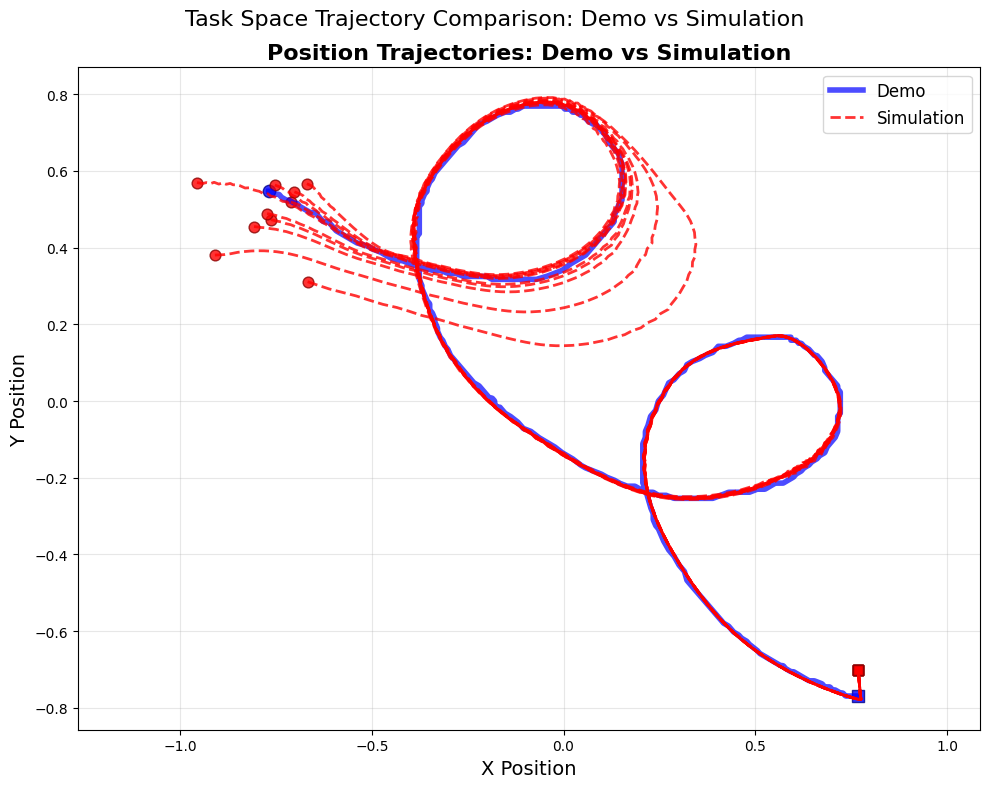


📊 Trajectory Statistics Comparison:
  📏 Trajectory Lengths:
    - Demo: avg=2000.0, range=[2000, 2000]
    - Simulation: avg=1501.0, range=[1501, 1501]
  📍 Position Ranges:
    - Demo: [-0.769, 0.769]
    - Simulation: [-0.956, 0.792]
  🏃 Velocity Ranges:
    - Demo: [-0.003, 0.003]
    - Simulation: [-0.687, 0.880]

✅ Task space trajectory comparison completed!


In [30]:
# Task Space Trajectory Visualization: Demo vs Simulation

if 'simulated_trajectories' in locals() and 'demonstrations_eval' in locals():
    print("=== Task Space Trajectory Comparison: Demo vs Simulation ===")
    
    def plot_demo_vs_simulation_trajectories(demo_trajectories, sim_trajectories, max_trajectories=5):
        """
        데모 궤적과 시뮬레이션 궤적을 task space에서 함께 시각화
        
        Args:
            demo_trajectories: [n_demo, time_steps, state_dim]
            sim_trajectories: [time_steps, n_sim, state_dim]
            max_trajectories: 표시할 최대 궤적 수
        """
        # 시뮬레이션 궤적을 올바른 형태로 변환
        if sim_trajectories.ndim == 3 and sim_trajectories.shape[0] > sim_trajectories.shape[1]:
            # [time_steps, n_trajectories, state_dim] -> [n_trajectories, time_steps, state_dim]
            sim_trajectories = sim_trajectories.transpose(1, 0, 2)
        
        # 표시할 궤적 수 제한
        n_demo_to_show = min(max_trajectories, len(demo_trajectories))
        n_sim_to_show = min(max_trajectories, len(sim_trajectories))
        
        print(f"📊 Visualizing {n_demo_to_show} demo trajectories and {n_sim_to_show} simulated trajectories")
        
        # 위치와 속도 분리 시각화
        if demo_trajectories.shape[-1] >= 4:  # Position + Velocity
            # fig, axes = plt.subplots(2, 2, figsize=(16, 12))
            
            
            # # Position trajectories (x, y)
            # ax_pos = axes[0, 0]
            
            # # Demo trajectories - position
            # for i in range(n_demo_to_show):
            #     ax_pos.plot(demo_trajectories[i, :, 0], demo_trajectories[i, :, 1], 
            #                'b-', alpha=0.7, linewidth=2, label='Demo' if i == 0 else "")
            #     ax_pos.scatter(demo_trajectories[i, 0, 0], demo_trajectories[i, 0, 1], 
            #                   c='blue', s=60, marker='o', alpha=0.8)
            #     ax_pos.scatter(demo_trajectories[i, -1, 0], demo_trajectories[i, -1, 1], 
            #                   c='blue', s=60, marker='x', alpha=0.8)
            
            # # Simulation trajectories - position
            # for i in range(n_sim_to_show):
            #     ax_pos.plot(sim_trajectories[i, :, 0], sim_trajectories[i, :, 1], 
            #                'r--', alpha=0.6, linewidth=1.5, label='Simulation' if i == 0 else "")
            #     ax_pos.scatter(sim_trajectories[i, 0, 0], sim_trajectories[i, 0, 1], 
            #                   c='red', s=40, marker='o', alpha=0.8)
            #     ax_pos.scatter(sim_trajectories[i, -1, 0], sim_trajectories[i, -1, 1], 
            #                   c='red', s=40, marker='x', alpha=0.8)
            
            # ax_pos.set_xlabel('X Position')
            # ax_pos.set_ylabel('Y Position')
            # ax_pos.set_title('Position Trajectories (x, y)')
            # ax_pos.legend()
            # ax_pos.grid(True, alpha=0.3)
            # ax_pos.axis('equal')
            
            plt.figure(figsize=(10, 8))
        
            # Demo trajectories - position
            for i in range(n_demo_to_show):
                plt.plot(demo_trajectories[i, :, 0], demo_trajectories[i, :, 1], 
                    'b-', alpha=0.7, linewidth=4, label='Demo' if i == 0 else "")
                plt.scatter(demo_trajectories[i, 0, 0], demo_trajectories[i, 0, 1], 
                        c='blue', s=80, marker='o', alpha=0.8, edgecolors='darkblue')
                plt.scatter(demo_trajectories[i, -1, 0], demo_trajectories[i, -1, 1], 
                        c='blue', s=80, marker='s', alpha=0.8, edgecolors='darkblue')
            
            # Simulation trajectories - position
            for i in range(n_sim_to_show):
                plt.plot(sim_trajectories[i, :, 0], sim_trajectories[i, :, 1], 
                    'r--', alpha=0.8, linewidth=2, label='Simulation' if i == 0 else "")
                plt.scatter(sim_trajectories[i, 0, 0], sim_trajectories[i, 0, 1], 
                        c='red', s=60, marker='o', alpha=0.8, edgecolors='darkred')
                plt.scatter(sim_trajectories[i, -1, 0], sim_trajectories[i, -1, 1], 
                        c='red', s=60, marker='s', alpha=0.8, edgecolors='darkred')
            
            plt.xlabel('X Position', fontsize=14)
            plt.ylabel('Y Position', fontsize=14)
            plt.title('Position Trajectories: Demo vs Simulation', fontsize=16, fontweight='bold')
            plt.legend(loc='best', fontsize=12)
            plt.grid(True, alpha=0.3)
            plt.axis('equal')
        
            
        #     # Velocity trajectories (vx, vy)
        #     ax_vel = axes[0, 1]
            
        #     # Demo trajectories - velocity
        #     for i in range(n_demo_to_show):
        #         ax_vel.plot(demo_trajectories[i, :, 2], demo_trajectories[i, :, 3], 
        #                    'b-', alpha=0.7, linewidth=2, label='Demo' if i == 0 else "")
        #         ax_vel.scatter(demo_trajectories[i, 0, 2], demo_trajectories[i, 0, 3], 
        #                       c='blue', s=60, marker='o', alpha=0.8)
            
        #     # Simulation trajectories - velocity
        #     for i in range(n_sim_to_show):
        #         ax_vel.plot(sim_trajectories[i, :, 2], sim_trajectories[i, :, 3], 
        #                    'r--', alpha=0.6, linewidth=1.5, label='Simulation' if i == 0 else "")
        #         ax_vel.scatter(sim_trajectories[i, 0, 2], sim_trajectories[i, 0, 3], 
        #                       c='red', s=40, marker='o', alpha=0.8)
            
        #     ax_vel.set_xlabel('X Velocity')
        #     ax_vel.set_ylabel('Y Velocity')
        #     ax_vel.set_title('Velocity Trajectories (vx, vy)')
        #     ax_vel.legend()
        #     ax_vel.grid(True, alpha=0.3)
            
        #     # Time series - X position
        #     ax_x_time = axes[1, 0]
            
        #     for i in range(n_demo_to_show):
        #         time_steps_demo = np.arange(len(demo_trajectories[i]))
        #         ax_x_time.plot(time_steps_demo, demo_trajectories[i, :, 0], 
        #                       'b-', alpha=0.7, linewidth=2, label='Demo' if i == 0 else "")
            
        #     for i in range(n_sim_to_show):
        #         time_steps_sim = np.arange(len(sim_trajectories[i]))
        #         ax_x_time.plot(time_steps_sim, sim_trajectories[i, :, 0], 
        #                       'r--', alpha=0.6, linewidth=1.5, label='Simulation' if i == 0 else "")
            
        #     ax_x_time.set_xlabel('Time Step')
        #     ax_x_time.set_ylabel('X Position')
        #     ax_x_time.set_title('X Position vs Time')
        #     ax_x_time.legend()
        #     ax_x_time.grid(True, alpha=0.3)
            
        #     # Time series - Y position
        #     ax_y_time = axes[1, 1]
            
        #     for i in range(n_demo_to_show):
        #         time_steps_demo = np.arange(len(demo_trajectories[i]))
        #         ax_y_time.plot(time_steps_demo, demo_trajectories[i, :, 1], 
        #                       'b-', alpha=0.7, linewidth=2, label='Demo' if i == 0 else "")
            
        #     for i in range(n_sim_to_show):
        #         time_steps_sim = np.arange(len(sim_trajectories[i]))
        #         ax_y_time.plot(time_steps_sim, sim_trajectories[i, :, 1], 
        #                       'r--', alpha=0.6, linewidth=1.5, label='Simulation' if i == 0 else "")
            
        #     ax_y_time.set_xlabel('Time Step')
        #     ax_y_time.set_ylabel('Y Position')
        #     ax_y_time.set_title('Y Position vs Time')
        #     ax_y_time.legend()
        #     ax_y_time.grid(True, alpha=0.3)
            
        # else:
        #     # 2차원인 경우
        #     fig, axes = plt.subplots(1, 2, figsize=(16, 6))
            
        #     # 2D trajectory plot
        #     ax_traj = axes[0]
            
        #     # Demo trajectories
        #     for i in range(n_demo_to_show):
        #         ax_traj.plot(demo_trajectories[i, :, 0], demo_trajectories[i, :, 1], 
        #                     'b-', alpha=0.7, linewidth=2, label='Demo' if i == 0 else "")
        #         ax_traj.scatter(demo_trajectories[i, 0, 0], demo_trajectories[i, 0, 1], 
        #                        c='blue', s=60, marker='o', alpha=0.8)
        #         ax_traj.scatter(demo_trajectories[i, -1, 0], demo_trajectories[i, -1, 1], 
        #                        c='blue', s=60, marker='x', alpha=0.8)
            
        #     # Simulation trajectories
        #     for i in range(n_sim_to_show):
        #         ax_traj.plot(sim_trajectories[i, :, 0], sim_trajectories[i, :, 1], 
        #                     'r--', alpha=0.6, linewidth=1.5, label='Simulation' if i == 0 else "")
        #         ax_traj.scatter(sim_trajectories[i, 0, 0], sim_trajectories[i, 0, 1], 
        #                        c='red', s=40, marker='o', alpha=0.8)
        #         ax_traj.scatter(sim_trajectories[i, -1, 0], sim_trajectories[i, -1, 1], 
        #                        c='red', s=40, marker='x', alpha=0.8)
            
        #     ax_traj.set_xlabel('Dimension 1')
        #     ax_traj.set_ylabel('Dimension 2')
        #     ax_traj.set_title('2D Trajectories')
        #     ax_traj.legend()
        #     ax_traj.grid(True, alpha=0.3)
        #     ax_traj.axis('equal')
            
        #     # Distance from start
        #     ax_dist = axes[1]
            
        #     for i in range(n_demo_to_show):
        #         start_pos = demo_trajectories[i, 0, :2]
        #         distances = np.linalg.norm(demo_trajectories[i, :, :2] - start_pos, axis=1)
        #         time_steps = np.arange(len(distances))
        #         ax_dist.plot(time_steps, distances, 'b-', alpha=0.7, linewidth=2, 
        #                     label='Demo' if i == 0 else "")
            
        #     for i in range(n_sim_to_show):
        #         start_pos = sim_trajectories[i, 0, :2]
        #         distances = np.linalg.norm(sim_trajectories[i, :, :2] - start_pos, axis=1)
        #         time_steps = np.arange(len(distances))
        #         ax_dist.plot(time_steps, distances, 'r--', alpha=0.6, linewidth=1.5, 
        #                     label='Simulation' if i == 0 else "")
            
        #     ax_dist.set_xlabel('Time Step')
        #     ax_dist.set_ylabel('Distance from Start')
        #     ax_dist.set_title('Distance from Starting Point')
        #     ax_dist.legend()
        #     ax_dist.grid(True, alpha=0.3)
        
        plt.suptitle('Task Space Trajectory Comparison: Demo vs Simulation', fontsize=16)
        plt.tight_layout()
        plt.show()
        
        # 통계 분석
        print("\n📊 Trajectory Statistics Comparison:")
        
        # 궤적 길이 비교
        demo_lengths = [len(traj) for traj in demo_trajectories[:n_demo_to_show]]
        sim_lengths = [len(traj) for traj in sim_trajectories[:n_sim_to_show]]
        
        print(f"  📏 Trajectory Lengths:")
        print(f"    - Demo: avg={np.mean(demo_lengths):.1f}, range=[{min(demo_lengths)}, {max(demo_lengths)}]")
        print(f"    - Simulation: avg={np.mean(sim_lengths):.1f}, range=[{min(sim_lengths)}, {max(sim_lengths)}]")
        
        # 위치 범위 비교
        demo_pos_range = [
            (np.min(demo_trajectories[:n_demo_to_show, :, :2]), np.max(demo_trajectories[:n_demo_to_show, :, :2]))
        ]
        sim_pos_range = [
            (np.min(sim_trajectories[:n_sim_to_show, :, :2]), np.max(sim_trajectories[:n_sim_to_show, :, :2]))
        ]
        
        print(f"  📍 Position Ranges:")
        print(f"    - Demo: [{demo_pos_range[0][0]:.3f}, {demo_pos_range[0][1]:.3f}]")
        print(f"    - Simulation: [{sim_pos_range[0][0]:.3f}, {sim_pos_range[0][1]:.3f}]")
        
        if demo_trajectories.shape[-1] >= 4:
            # 속도 범위 비교
            demo_vel_range = [
                (np.min(demo_trajectories[:n_demo_to_show, :, 2:4]), np.max(demo_trajectories[:n_demo_to_show, :, 2:4]))
            ]
            sim_vel_range = [
                (np.min(sim_trajectories[:n_sim_to_show, :, 2:4]), np.max(sim_trajectories[:n_sim_to_show, :, 2:4]))
            ]
            
            print(f"  🏃 Velocity Ranges:")
            print(f"    - Demo: [{demo_vel_range[0][0]:.3f}, {demo_vel_range[0][1]:.3f}]")
            print(f"    - Simulation: [{sim_vel_range[0][0]:.3f}, {sim_vel_range[0][1]:.3f}]")
    
    # 시각화 실행
    print(f"📊 Data shapes:")
    print(f"  - Demo trajectories: {demonstrations_eval.shape}")
    print(f"  - Simulated trajectories: {simulated_trajectories.shape}")
    
    plot_demo_vs_simulation_trajectories(
        demonstrations_eval, 
        simulated_trajectories, 
        max_trajectories=10
    )
    
    print("\n✅ Task space trajectory comparison completed!")
    
else:
    print("❌ Cannot compare trajectories.")
    print("Required: simulated_trajectories, demonstrations_eval")

In [31]:
# 11. Latent Space 궤적 변환 및 시각화

def convert_trajectories_to_latent_space(encoder, trajectories, primitive_type=None):
    """
    궤적들을 latent space로 변환
    
    Args:
        encoder: StandaloneEncoder 모델
        trajectories: 원본 궤적들 [n_trajectories, time_steps, state_dim] 또는 [time_steps, state_dim]
        primitive_type: 원시타입 (multi-motion인 경우)
        
    Returns:
        latent_trajectories: latent space 궤적들
    """
    encoder.eval()
    
    # 입력 형태 확인 및 조정
    if trajectories.ndim == 2:
        # 단일 궤적인 경우
        trajectories = trajectories.unsqueeze(0)
        single_trajectory = True
    else:
        single_trajectory = False
    
    n_trajectories, time_steps, state_dim = trajectories.shape
    
    # Tensor로 변환
    if not isinstance(trajectories, torch.Tensor):
        trajectories = torch.FloatTensor(trajectories)
    
    if torch.cuda.is_available():
        trajectories = trajectories.cuda()
    
    latent_trajectories = []
    
    with torch.no_grad():
        for traj_idx in range(n_trajectories):
            traj_latent = []
            for time_idx in range(time_steps):
                state = trajectories[traj_idx, time_idx].unsqueeze(0)  # [1, state_dim]
                
                # Primitive type 설정
                if primitive_type is not None:
                    if isinstance(primitive_type, int):
                        prim_type = torch.tensor([primitive_type], dtype=torch.long)
                        if torch.cuda.is_available():
                            prim_type = prim_type.cuda()
                    else:
                        prim_type = primitive_type
                else:
                    prim_type = None
                
                # Latent space로 인코딩
                latent_state = encoder(state, prim_type)
                traj_latent.append(latent_state.cpu().numpy())
            
            latent_trajectories.append(np.concatenate(traj_latent, axis=0))
    
    latent_trajectories = np.array(latent_trajectories)  # [n_trajectories, time_steps, latent_dim]
    
    if single_trajectory:
        latent_trajectories = latent_trajectories.squeeze(0)
    
    return latent_trajectories

def plot_latent_space_trajectories(demo_latent, sim_latent=None, title="Latent Space Trajectories"):
    """
    Latent space에서 궤적들을 시각화
    
    Args:
        demo_latent: 데모 궤적들 [n_demos, time_steps, latent_dim]
        sim_latent: 시뮬레이션 궤적들 [n_sims, time_steps, latent_dim] (옵션)
        title: 그래프 제목
    """
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    
    latent_dim = demo_latent.shape[-1]
    
    if latent_dim >= 4:
        # 4차원 이상인 경우 처음 4개 차원 사용
        fig = plt.figure(figsize=(16, 12))
        
        # 2D 투영들 (6개 subplot)
        projections = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]
        
        for i, (dim1, dim2) in enumerate(projections):
            ax = fig.add_subplot(2, 3, i+1)
            
            # 데모 궤적들 그리기
            for demo_idx in range(len(demo_latent)):
                ax.plot(demo_latent[demo_idx, :, dim1], demo_latent[demo_idx, :, dim2], 
                       'b-', alpha=0.7, linewidth=2, label='Demo' if demo_idx == 0 else "")
                ax.scatter(demo_latent[demo_idx, 0, dim1], demo_latent[demo_idx, 0, dim2], 
                          c='blue', s=50, marker='o', alpha=0.8)
            
            # 시뮬레이션 궤적들 그리기
            for sim_idx in range(len(sim_latent)):
                ax.plot(sim_latent[sim_idx, :, dim1], sim_latent[sim_idx, :, dim2], 
                       'r-', alpha=0.6, linewidth=1, label='Simulation' if sim_idx == 0 else "")
                ax.scatter(sim_latent[sim_idx, 0, dim1], sim_latent[sim_idx, 0, dim2], 
                          c='red', s=30, marker='x', alpha=0.8)
            
            ax.set_xlabel(f'Latent Dim {dim1+1}')
            ax.set_ylabel(f'Latent Dim {dim2+1}')
            ax.set_title(f'Dimensions {dim1+1} vs {dim2+1}')
            ax.grid(True, alpha=0.3)
            if i == 0:
                ax.legend()
        
        plt.suptitle(f'{title} - 2D Projections', fontsize=16)
        plt.tight_layout()
        plt.show()
        
        # 3D 시각화 (첫 3개 차원)
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # 데모 궤적들
        for demo_idx in range(len(demo_latent)):
            ax.plot(demo_latent[demo_idx, :, 0], demo_latent[demo_idx, :, 1], demo_latent[demo_idx, :, 2],
                   'b-', alpha=0.7, linewidth=2, label='Demo' if demo_idx == 0 else "")
            ax.scatter(demo_latent[demo_idx, 0, 0], demo_latent[demo_idx, 0, 1], demo_latent[demo_idx, 0, 2],
                      c='blue', s=50, marker='o')
        
        # 시뮬레이션 궤적들
        for sim_idx in range(len(sim_latent)):
            ax.plot(sim_latent[sim_idx, :, 0], sim_latent[sim_idx, :, 1], sim_latent[sim_idx, :, 2],
                   'r-', alpha=0.6, linewidth=1, label='Simulation' if sim_idx == 0 else "")
            ax.scatter(sim_latent[sim_idx, 0, 0], sim_latent[sim_idx, 0, 1], sim_latent[sim_idx, 0, 2],
                      c='red', s=30, marker='x')
        
        ax.set_xlabel('Latent Dim 1')
        ax.set_ylabel('Latent Dim 2')
        ax.set_zlabel('Latent Dim 3')
        ax.set_title(f'{title} - 3D View (Dims 1-3)')
        ax.legend()
        plt.show()
        
    elif latent_dim == 3:
        # 3차원인 경우
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # 데모 궤적들
        for demo_idx in range(len(demo_latent)):
            ax.plot(demo_latent[demo_idx, :, 0], demo_latent[demo_idx, :, 1], demo_latent[demo_idx, :, 2],
                   'b-', alpha=0.7, linewidth=2, label='Demo' if demo_idx == 0 else "")
        
        # 시뮬레이션 궤적들
        for sim_idx in range(len(sim_latent)):
            ax.plot(sim_latent[sim_idx, :, 0], sim_latent[sim_idx, :, 1], sim_latent[sim_idx, :, 2],
                   'r-', alpha=0.6, linewidth=1, label='Simulation' if sim_idx == 0 else "")
        
        ax.set_xlabel('Latent Dim 1')
        ax.set_ylabel('Latent Dim 2')
        ax.set_zlabel('Latent Dim 3')
        ax.set_title(title)
        ax.legend()
        plt.show()
        
    else:
        # 2차원인 경우
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # 데모 궤적들
        for demo_idx in range(len(demo_latent)):
            ax.plot(demo_latent[demo_idx, :, 0], demo_latent[demo_idx, :, 1],
                   'b-', alpha=0.7, linewidth=2, label='Demo' if demo_idx == 0 else "")
        
        # 시뮬레이션 궤적들
        for sim_idx in range(len(sim_latent)):
            ax.plot(sim_latent[sim_idx, :, 0], sim_latent[sim_idx, :, 1],
                   'r-', alpha=0.6, linewidth=1, label='Simulation' if sim_idx == 0 else "")
        
        ax.set_xlabel('Latent Dim 1')
        ax.set_ylabel('Latent Dim 2')
        ax.set_title(title)
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.show()

def analyze_latent_space_statistics(demo_latent, sim_latent=None):
    """
    Latent space에서 궤적들의 통계 분석
    """
    print("=== Latent Space 통계 분석 ===")
    
    # 데모 궤적 통계
    demo_mean = np.mean(demo_latent, axis=(0, 1))
    demo_std = np.std(demo_latent, axis=(0, 1))
    demo_range = (np.min(demo_latent, axis=(0, 1)), np.max(demo_latent, axis=(0, 1)))
    
    print("\n📊 데모 궤적 (Latent Space):")
    print(f"  - 형태: {demo_latent.shape}")
    print(f"  - 평균: {demo_mean}")
    print(f"  - 표준편차: {demo_std}")
    print(f"  - 범위: {demo_range[0]} ~ {demo_range[1]}")
    
    if sim_latent is not None:
        # 시뮬레이션 궤적 통계
        sim_mean = np.mean(sim_latent, axis=(0, 1))
        sim_std = np.std(sim_latent, axis=(0, 1))
        sim_range = (np.min(sim_latent, axis=(0, 1)), np.max(sim_latent, axis=(0, 1)))
        
        print("\n📊 시뮬레이션 궤적 (Latent Space):")
        print(f"  - 형태: {sim_latent.shape}")
        print(f"  - 평균: {sim_mean}")
        print(f"  - 표준편차: {sim_std}")
        print(f"  - 범위: {sim_range[0]} ~ {sim_range[1]}")
        
        # 평균 차이 분석
        mean_diff = np.abs(demo_mean - sim_mean)
        print(f"\n🔍 평균 차이: {mean_diff}")
        print(f"🔍 평균 차이 크기: {np.linalg.norm(mean_diff):.6f}")

print("✓ Latent space 궤적 변환 및 시각화 함수들이 정의되었습니다!")

✓ Latent space 궤적 변환 및 시각화 함수들이 정의되었습니다!


In [32]:
# Debug: CONDOR Model Structure Investigation

if 'learner' in locals():
    print("=== CONDOR Model Structure Debug ===")
    
    # 모델 속성 확인
    print("\n🔍 Model attributes:")
    model_attrs = [attr for attr in dir(learner.model) if not attr.startswith('_')]
    for attr in model_attrs:
        if 'decoder' in attr.lower() or 'encoder' in attr.lower():
            print(f"  - {attr}: {type(getattr(learner.model, attr))}")
    
    # 모든 named_modules 확인
    print("\n🔍 All named modules:")
    for name, module in learner.model.named_modules():
        if 'decoder' in name.lower() or 'encoder' in name.lower():
            print(f"  - {name}: {type(module)}")
    
    # 파라미터 확인
    print("\n🔍 Named parameters (decoder related):")
    for name, param in learner.model.named_parameters():
        if 'decoder' in name.lower():
            print(f"  - {name}: {param.shape}")
    
    # 모델이 호출 가능한지 확인
    print(f"\n🔍 Model callable: {callable(learner.model)}")
    
    # 간단한 테스트를 통해 모델 입출력 확인
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    
    try:
        # 테스트 입력 생성 (4차원 task space)
        test_input = torch.randn(1, 4).to(device)
        print(f"\n🧪 Test input shape: {test_input.shape}")
        
        # 전체 모델 forward pass 시도
        if hasattr(learner.model, 'encoder'):
            encoder_output = learner.model.encoder(test_input, None)
            print(f"✓ Encoder output shape: {encoder_output.shape}")
        else:
            print("❌ No 'encoder' attribute found")
        
        # 개별 decoder 레이어 확인
        decoder_layers = ['decoder1_dx', 'decoder2_dx', 'decoder3_dx']
        for layer_name in decoder_layers:
            if hasattr(learner.model, layer_name):
                layer = getattr(learner.model, layer_name)
                print(f"✓ Found {layer_name}: {layer}")
            else:
                print(f"❌ No {layer_name} found")
                
    except Exception as e:
        print(f"❌ Error during model testing: {e}")
    
    print("\n" + "="*50)
else:
    print("❌ No learner object found for debugging")

=== CONDOR Model Structure Debug ===

🔍 Model attributes:
  - decoder1_dx: <class 'torch.nn.modules.linear.Linear'>
  - decoder2_dx: <class 'torch.nn.modules.linear.Linear'>
  - decoder3_dx: <class 'torch.nn.modules.linear.Linear'>
  - decoder_dx: <class 'method'>
  - encoder: <class 'method'>
  - encoder1: <class 'torch.nn.modules.linear.Linear'>
  - encoder2: <class 'torch.nn.modules.linear.Linear'>
  - encoder3: <class 'torch.nn.modules.linear.Linear'>

🔍 All named modules:
  - encoder1: <class 'torch.nn.modules.linear.Linear'>
  - encoder2: <class 'torch.nn.modules.linear.Linear'>
  - encoder3: <class 'torch.nn.modules.linear.Linear'>
  - decoder1_dx: <class 'torch.nn.modules.linear.Linear'>
  - decoder2_dx: <class 'torch.nn.modules.linear.Linear'>
  - decoder3_dx: <class 'torch.nn.modules.linear.Linear'>

🔍 Named parameters (decoder related):
  - decoder1_dx.weight: torch.Size([300, 4])
  - decoder1_dx.bias: torch.Size([300])
  - decoder2_dx.weight: torch.Size([300, 300])
  - deco